In [1]:
from torchcp.classification.predictors import SplitPredictor
from torchcp.classification.scores import THR, APS, SAPS, RAPS, THRRANK
import torch
import pandas as pd
import numpy as np
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt; plt.style.use('default')
import os


def evaluation(cal_x, cal_y, test_x, test_y, score_function, score_function_param=None,
                        alpha=0.01, dataset='NLP'):
    print(
        f"Experiment--Data : {dataset}, Score : {score_function.__name__}, Predictor : SplitPredictor, Alpha : {alpha}")
    
    if not torch.is_tensor(cal_x):
        cal_x = torch.from_numpy(cal_x).double()
        cal_y = torch.from_numpy(cal_y).long()
        test_x = torch.from_numpy(test_x).double()
        test_y = torch.from_numpy(test_y).long()
        
    if score_function_param is not None:
        if isinstance(score_function_param, tuple):
            predictor = SplitPredictor(score_function(*score_function_param))
        else:
            predictor = SplitPredictor(score_function(score_function_param))
    else:
        predictor = SplitPredictor(score_function())

    predictor.calculate_threshold(cal_x, cal_y, alpha)
    prediction_sets = []
    labels_list = []
    prediction_sets = predictor.predict_with_logits(test_x)
    # prediction_sets.append(prediction_sets_batch)
    labels_list = test_y
    
    metrics = predictor.evaluate_scores(prediction_sets, torch.Tensor(labels_list).long(), alpha)
    coverage = np.round(metrics['Coverage_rate'], 3)
    size = np.round(metrics['Average_size'], 3)
    sscv = np.round(metrics['SSCV'], 3)
    print(f"Coverage: {coverage}; Size: {size}; SSCV: {sscv}")

    # Create a DataFrame to store the evaluation metrics
    metrics_df = pd.DataFrame({'Data': [dataset],
                               'Alpha': [alpha],
                               'Score Function': [score_function.__name__],
                               'Coverage': [coverage],
                               'Size': [size], 
                               'SSCV': [sscv]})
    return metrics_df



# Load softmax scores and correct answers for each multiple choice question

datasets = {
    'college medicine': {
        'scores': np.load(data_dir / 'college_medicine_scores.npy'),
        'targets': np.load(data_dir / 'college_medicine_targets.npy'),
    },
    'marketing': {
        'scores': np.load(data_dir / 'marketing_scores.npy'),
        'targets': np.load(data_dir / 'marketing_targets.npy'),
    },
    'public relations': {
        'scores': np.load(data_dir / 'public_relations_scores.npy'),
        'targets': np.load(data_dir / 'public_relations_targets.npy'),
    }
}

datasets = {k: datasets[k] for k in list(datasets.keys())}


In [3]:
alphas = np.linspace(0.1, 0.3, 11) # np.linspace(0.2, 0.6, 5)
score_functions = [THRRANK, APS, RAPS, SAPS]  #
score_function_params = {RAPS: (0.2, 2), SAPS: 0.2}
num_repetitions = 100
results_df = pd.DataFrame(columns=['Data', 'Alpha', 'Score Function', 'Coverage', 'Size', 'SSCV'])

for alpha in alphas:
    for name, results in datasets.items():
        if name in ['college medicine', 'marketing', 'public relations']: # 'clinical knowledge'
            scores = results['scores'][0] #[np.random.randint(results['scores'].shape[0])]
            # scores = results['scores'].mean(0)
            targets = results['targets']
            index = np.arange(len(scores))

            for score_function in score_functions:
                coverage_values = []
                size_values = []
                sscv_values = []
                for run_id in range(num_repetitions):
                    np.random.shuffle(index)
                    n = len(scores) // 2
                    cal_scores = scores[index][:n]
                    val_scores = scores[index][n:]
                    cal_targets = targets[index][:n]
                    val_targets = targets[index][n:]

                    if score_function in score_function_params:
                        score_function_param = score_function_params[score_function]
                    else:
                        score_function_param = None

                    metrics_df = evaluation(cal_scores, cal_targets, val_scores, val_targets, score_function, score_function_param, alpha=alpha, dataset=name)
                    coverage_values.append(metrics_df['Coverage'].values[0])
                    size_values.append(metrics_df['Size'].values[0])
                    sscv_values.append(metrics_df['SSCV'].values[0])


                # Calculate the median-of-means for coverage and size
                median_coverage = pd.Series(coverage_values).mean()
                median_size = pd.Series(size_values).mean()
                median_sscv = pd.Series(sscv_values).mean()

                # Add the median-of-means results to the DataFrame
                results_df.loc[len(results_df)] = [name, alpha,
                                                   f"Ours ({score_function})" if isinstance(score_function,
                                                                                            str) else score_function.__name__,
                                                   median_coverage, median_size, median_sscv]




Experiment--Data : college medicine, Score : THRRANK, Predictor : SplitPredictor, Alpha : 0.1
Coverage: 0.875; Size: 3.323; SSCV: 0.1
Experiment--Data : college medicine, Score : THRRANK, Predictor : SplitPredictor, Alpha : 0.1
Coverage: 0.896; Size: 3.219; SSCV: 0.1
Experiment--Data : college medicine, Score : THRRANK, Predictor : SplitPredictor, Alpha : 0.1
Coverage: 0.917; Size: 3.406; SSCV: 0.1
Experiment--Data : college medicine, Score : THRRANK, Predictor : SplitPredictor, Alpha : 0.1
Coverage: 0.823; Size: 3.135; SSCV: 0.105
Experiment--Data : college medicine, Score : THRRANK, Predictor : SplitPredictor, Alpha : 0.1
Coverage: 0.927; Size: 3.354; SSCV: 0.1
Experiment--Data : college medicine, Score : THRRANK, Predictor : SplitPredictor, Alpha : 0.1
Coverage: 0.917; Size: 3.438; SSCV: 0.1
Experiment--Data : college medicine, Score : THRRANK, Predictor : SplitPredictor, Alpha : 0.1
Coverage: 0.906; Size: 3.292; SSCV: 0.1
Experiment--Data : college medicine, Score : THRRANK, Predic

Coverage: 0.844; Size: 3.146; SSCV: 0.1
Experiment--Data : college medicine, Score : APS, Predictor : SplitPredictor, Alpha : 0.1
Coverage: 0.844; Size: 3.25; SSCV: 0.108
Experiment--Data : college medicine, Score : APS, Predictor : SplitPredictor, Alpha : 0.1
Coverage: 0.875; Size: 3.25; SSCV: 0.1
Experiment--Data : college medicine, Score : APS, Predictor : SplitPredictor, Alpha : 0.1
Coverage: 0.885; Size: 3.302; SSCV: 0.1
Experiment--Data : college medicine, Score : APS, Predictor : SplitPredictor, Alpha : 0.1
Coverage: 0.896; Size: 3.281; SSCV: 0.1
Experiment--Data : college medicine, Score : APS, Predictor : SplitPredictor, Alpha : 0.1
Coverage: 0.896; Size: 3.469; SSCV: 0.1
Experiment--Data : college medicine, Score : APS, Predictor : SplitPredictor, Alpha : 0.1
Coverage: 0.875; Size: 3.365; SSCV: 0.1
Experiment--Data : college medicine, Score : APS, Predictor : SplitPredictor, Alpha : 0.1
Coverage: 0.906; Size: 3.542; SSCV: 0.105
Experiment--Data : college medicine, Score : APS

Experiment--Data : college medicine, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.1
Coverage: 0.958; Size: 3.615; SSCV: 0.1
Experiment--Data : college medicine, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.1
Coverage: 0.885; Size: 3.448; SSCV: 0.108
Experiment--Data : college medicine, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.1
Coverage: 0.938; Size: 3.521; SSCV: 0.1
Experiment--Data : college medicine, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.1
Coverage: 0.938; Size: 3.594; SSCV: 0.1
Experiment--Data : college medicine, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.1
Coverage: 0.802; Size: 3.146; SSCV: 0.132
Experiment--Data : college medicine, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.1
Coverage: 0.823; Size: 3.104; SSCV: 0.1
Experiment--Data : college medicine, Score : SAPS, Predictor : SplitPredictor, Alpha : 0.1
Coverage: 0.906; Size: 3.312; SSCV: 0.1
Experiment--Data : college medicine, Score : SAPS, Predictor : SplitPredictor, 

Coverage: 0.962; Size: 3.069; SSCV: 0.1
Experiment--Data : marketing, Score : THRRANK, Predictor : SplitPredictor, Alpha : 0.1
Coverage: 0.838; Size: 2.315; SSCV: 0.062
Experiment--Data : marketing, Score : THRRANK, Predictor : SplitPredictor, Alpha : 0.1
Coverage: 0.938; Size: 3.0; SSCV: 0.038
Experiment--Data : marketing, Score : THRRANK, Predictor : SplitPredictor, Alpha : 0.1
Coverage: 0.908; Size: 2.677; SSCV: 0.008
Experiment--Data : marketing, Score : THRRANK, Predictor : SplitPredictor, Alpha : 0.1
Coverage: 0.954; Size: 3.069; SSCV: 0.1
Experiment--Data : marketing, Score : THRRANK, Predictor : SplitPredictor, Alpha : 0.1
Coverage: 0.908; Size: 2.723; SSCV: 0.008
Experiment--Data : marketing, Score : THRRANK, Predictor : SplitPredictor, Alpha : 0.1
Coverage: 0.877; Size: 2.515; SSCV: 0.023
Experiment--Data : marketing, Score : THRRANK, Predictor : SplitPredictor, Alpha : 0.1
Coverage: 0.931; Size: 2.785; SSCV: 0.031
Experiment--Data : marketing, Score : THRRANK, Predictor : Sp

Coverage: 0.908; Size: 2.723; SSCV: 0.008
Experiment--Data : marketing, Score : APS, Predictor : SplitPredictor, Alpha : 0.1
Coverage: 0.977; Size: 3.108; SSCV: 0.1
Experiment--Data : marketing, Score : APS, Predictor : SplitPredictor, Alpha : 0.1
Coverage: 0.892; Size: 2.762; SSCV: 0.008
Experiment--Data : marketing, Score : APS, Predictor : SplitPredictor, Alpha : 0.1
Coverage: 0.915; Size: 2.746; SSCV: 0.015
Experiment--Data : marketing, Score : APS, Predictor : SplitPredictor, Alpha : 0.1
Coverage: 0.938; Size: 3.085; SSCV: 0.1
Experiment--Data : marketing, Score : APS, Predictor : SplitPredictor, Alpha : 0.1
Coverage: 0.954; Size: 3.069; SSCV: 0.1
Experiment--Data : marketing, Score : APS, Predictor : SplitPredictor, Alpha : 0.1
Coverage: 0.923; Size: 2.946; SSCV: 0.023
Experiment--Data : marketing, Score : APS, Predictor : SplitPredictor, Alpha : 0.1
Coverage: 0.931; Size: 2.908; SSCV: 0.031
Experiment--Data : marketing, Score : APS, Predictor : SplitPredictor, Alpha : 0.1
Covera

Coverage: 0.915; Size: 2.823; SSCV: 0.1
Experiment--Data : marketing, Score : SAPS, Predictor : SplitPredictor, Alpha : 0.1
Coverage: 0.915; Size: 2.769; SSCV: 0.1
Experiment--Data : marketing, Score : SAPS, Predictor : SplitPredictor, Alpha : 0.1
Coverage: 0.862; Size: 2.662; SSCV: 0.038
Experiment--Data : marketing, Score : SAPS, Predictor : SplitPredictor, Alpha : 0.1
Coverage: 0.938; Size: 2.985; SSCV: 0.1
Experiment--Data : marketing, Score : SAPS, Predictor : SplitPredictor, Alpha : 0.1
Coverage: 0.908; Size: 2.792; SSCV: 0.008
Experiment--Data : marketing, Score : SAPS, Predictor : SplitPredictor, Alpha : 0.1
Coverage: 0.869; Size: 2.546; SSCV: 0.1
Experiment--Data : marketing, Score : SAPS, Predictor : SplitPredictor, Alpha : 0.1
Coverage: 0.962; Size: 2.969; SSCV: 0.1
Experiment--Data : marketing, Score : SAPS, Predictor : SplitPredictor, Alpha : 0.1
Coverage: 0.877; Size: 2.615; SSCV: 0.023
Experiment--Data : marketing, Score : SAPS, Predictor : SplitPredictor, Alpha : 0.1
Co

Coverage: 0.903; Size: 3.194; SSCV: 0.1
Experiment--Data : public relations, Score : APS, Predictor : SplitPredictor, Alpha : 0.1
Coverage: 0.919; Size: 3.355; SSCV: 0.1
Experiment--Data : public relations, Score : APS, Predictor : SplitPredictor, Alpha : 0.1
Coverage: 0.839; Size: 3.081; SSCV: 0.1
Experiment--Data : public relations, Score : APS, Predictor : SplitPredictor, Alpha : 0.1
Coverage: 0.903; Size: 3.532; SSCV: 0.107
Experiment--Data : public relations, Score : APS, Predictor : SplitPredictor, Alpha : 0.1
Coverage: 0.855; Size: 3.339; SSCV: 0.12
Experiment--Data : public relations, Score : APS, Predictor : SplitPredictor, Alpha : 0.1
Coverage: 0.839; Size: 3.032; SSCV: 0.1
Experiment--Data : public relations, Score : APS, Predictor : SplitPredictor, Alpha : 0.1
Coverage: 0.855; Size: 3.339; SSCV: 0.12
Experiment--Data : public relations, Score : APS, Predictor : SplitPredictor, Alpha : 0.1
Coverage: 0.952; Size: 3.5; SSCV: 0.1
Experiment--Data : public relations, Score : APS

Coverage: 0.903; Size: 3.242; SSCV: 0.1
Experiment--Data : public relations, Score : SAPS, Predictor : SplitPredictor, Alpha : 0.1
Coverage: 0.919; Size: 3.661; SSCV: 0.138
Experiment--Data : public relations, Score : SAPS, Predictor : SplitPredictor, Alpha : 0.1
Coverage: 0.968; Size: 3.677; SSCV: 0.1
Experiment--Data : public relations, Score : SAPS, Predictor : SplitPredictor, Alpha : 0.1
Coverage: 0.952; Size: 3.597; SSCV: 0.1
Experiment--Data : public relations, Score : SAPS, Predictor : SplitPredictor, Alpha : 0.1
Coverage: 0.855; Size: 3.21; SSCV: 0.1
Experiment--Data : public relations, Score : SAPS, Predictor : SplitPredictor, Alpha : 0.1
Coverage: 0.919; Size: 3.194; SSCV: 0.1
Experiment--Data : public relations, Score : SAPS, Predictor : SplitPredictor, Alpha : 0.1
Coverage: 0.968; Size: 3.516; SSCV: 0.1
Experiment--Data : public relations, Score : SAPS, Predictor : SplitPredictor, Alpha : 0.1
Coverage: 0.839; Size: 3.161; SSCV: 0.104
Experiment--Data : public relations, Sco

Coverage: 0.906; Size: 3.333; SSCV: 0.12
Experiment--Data : college medicine, Score : APS, Predictor : SplitPredictor, Alpha : 0.12
Coverage: 0.906; Size: 3.365; SSCV: 0.12
Experiment--Data : college medicine, Score : APS, Predictor : SplitPredictor, Alpha : 0.12
Coverage: 0.802; Size: 3.0; SSCV: 0.12
Experiment--Data : college medicine, Score : APS, Predictor : SplitPredictor, Alpha : 0.12
Coverage: 0.927; Size: 3.406; SSCV: 0.12
Experiment--Data : college medicine, Score : APS, Predictor : SplitPredictor, Alpha : 0.12
Coverage: 0.833; Size: 3.115; SSCV: 0.12
Experiment--Data : college medicine, Score : APS, Predictor : SplitPredictor, Alpha : 0.12
Coverage: 0.948; Size: 3.51; SSCV: 0.12
Experiment--Data : college medicine, Score : APS, Predictor : SplitPredictor, Alpha : 0.12
Coverage: 0.906; Size: 3.406; SSCV: 0.12
Experiment--Data : college medicine, Score : APS, Predictor : SplitPredictor, Alpha : 0.12
Coverage: 0.875; Size: 3.281; SSCV: 0.12
Experiment--Data : college medicine, S

Coverage: 0.906; Size: 3.5; SSCV: 0.12
Experiment--Data : college medicine, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.12
Coverage: 0.875; Size: 3.323; SSCV: 0.12
Experiment--Data : college medicine, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.12
Coverage: 0.865; Size: 3.167; SSCV: 0.12
Experiment--Data : college medicine, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.12
Coverage: 0.938; Size: 3.312; SSCV: 0.12
Experiment--Data : college medicine, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.12
Coverage: 0.938; Size: 3.521; SSCV: 0.12
Experiment--Data : college medicine, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.12
Coverage: 0.875; Size: 3.365; SSCV: 0.12
Experiment--Data : college medicine, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.12
Coverage: 0.875; Size: 3.344; SSCV: 0.12
Experiment--Data : college medicine, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.12
Coverage: 0.917; Size: 3.385; SSCV: 0.12
Experiment--Data : college med

Coverage: 0.854; Size: 2.277; SSCV: 0.026
Experiment--Data : marketing, Score : THRRANK, Predictor : SplitPredictor, Alpha : 0.12
Coverage: 0.946; Size: 2.815; SSCV: 0.066
Experiment--Data : marketing, Score : THRRANK, Predictor : SplitPredictor, Alpha : 0.12
Coverage: 0.892; Size: 2.569; SSCV: 0.012
Experiment--Data : marketing, Score : THRRANK, Predictor : SplitPredictor, Alpha : 0.12
Coverage: 0.846; Size: 2.292; SSCV: 0.034
Experiment--Data : marketing, Score : THRRANK, Predictor : SplitPredictor, Alpha : 0.12
Coverage: 0.862; Size: 2.3; SSCV: 0.018
Experiment--Data : marketing, Score : THRRANK, Predictor : SplitPredictor, Alpha : 0.12
Coverage: 0.854; Size: 2.262; SSCV: 0.026
Experiment--Data : marketing, Score : THRRANK, Predictor : SplitPredictor, Alpha : 0.12
Coverage: 0.823; Size: 2.162; SSCV: 0.057
Experiment--Data : marketing, Score : THRRANK, Predictor : SplitPredictor, Alpha : 0.12
Coverage: 0.9; Size: 2.562; SSCV: 0.02
Experiment--Data : marketing, Score : THRRANK, Predic

Coverage: 0.854; Size: 2.523; SSCV: 0.026
Experiment--Data : marketing, Score : APS, Predictor : SplitPredictor, Alpha : 0.12
Coverage: 0.769; Size: 2.046; SSCV: 0.126
Experiment--Data : marketing, Score : APS, Predictor : SplitPredictor, Alpha : 0.12
Coverage: 0.915; Size: 2.792; SSCV: 0.035
Experiment--Data : marketing, Score : APS, Predictor : SplitPredictor, Alpha : 0.12
Coverage: 0.946; Size: 2.885; SSCV: 0.066
Experiment--Data : marketing, Score : APS, Predictor : SplitPredictor, Alpha : 0.12
Coverage: 0.862; Size: 2.508; SSCV: 0.018
Experiment--Data : marketing, Score : APS, Predictor : SplitPredictor, Alpha : 0.12
Coverage: 0.854; Size: 2.508; SSCV: 0.026
Experiment--Data : marketing, Score : APS, Predictor : SplitPredictor, Alpha : 0.12
Coverage: 0.831; Size: 2.477; SSCV: 0.049
Experiment--Data : marketing, Score : APS, Predictor : SplitPredictor, Alpha : 0.12
Coverage: 0.908; Size: 2.792; SSCV: 0.028
Experiment--Data : marketing, Score : APS, Predictor : SplitPredictor, Alpha

Coverage: 0.846; Size: 2.362; SSCV: 0.034
Experiment--Data : marketing, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.12
Coverage: 0.892; Size: 2.715; SSCV: 0.012
Experiment--Data : marketing, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.12
Coverage: 0.885; Size: 2.615; SSCV: 0.005
Experiment--Data : marketing, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.12
Coverage: 0.877; Size: 2.523; SSCV: 0.003
Experiment--Data : marketing, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.12
Coverage: 0.854; Size: 2.331; SSCV: 0.026
Experiment--Data : marketing, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.12
Coverage: 0.877; Size: 2.723; SSCV: 0.003
Experiment--Data : marketing, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.12
Coverage: 0.823; Size: 2.315; SSCV: 0.057
Experiment--Data : marketing, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.12
Coverage: 0.931; Size: 2.885; SSCV: 0.051
Experiment--Data : marketing, Score : RAPS, Predictor : SplitPredicto

Experiment--Data : marketing, Score : SAPS, Predictor : SplitPredictor, Alpha : 0.12
Coverage: 0.923; Size: 2.792; SSCV: 0.12
Experiment--Data : marketing, Score : SAPS, Predictor : SplitPredictor, Alpha : 0.12
Coverage: 0.823; Size: 2.238; SSCV: 0.12
Experiment--Data : marketing, Score : SAPS, Predictor : SplitPredictor, Alpha : 0.12
Coverage: 0.877; Size: 2.546; SSCV: 0.12
Experiment--Data : marketing, Score : SAPS, Predictor : SplitPredictor, Alpha : 0.12
Coverage: 0.969; Size: 2.846; SSCV: 0.12
Experiment--Data : marketing, Score : SAPS, Predictor : SplitPredictor, Alpha : 0.12
Coverage: 0.908; Size: 2.738; SSCV: 0.028
Experiment--Data : marketing, Score : SAPS, Predictor : SplitPredictor, Alpha : 0.12
Coverage: 0.892; Size: 2.7; SSCV: 0.012
Experiment--Data : marketing, Score : SAPS, Predictor : SplitPredictor, Alpha : 0.12
Coverage: 0.908; Size: 2.7; SSCV: 0.028
Experiment--Data : marketing, Score : SAPS, Predictor : SplitPredictor, Alpha : 0.12
Coverage: 0.885; Size: 2.577; SSCV

Coverage: 0.79; Size: 2.919; SSCV: 0.09
Experiment--Data : public relations, Score : APS, Predictor : SplitPredictor, Alpha : 0.12
Coverage: 0.935; Size: 3.419; SSCV: 0.12
Experiment--Data : public relations, Score : APS, Predictor : SplitPredictor, Alpha : 0.12
Coverage: 0.919; Size: 3.548; SSCV: 0.12
Experiment--Data : public relations, Score : APS, Predictor : SplitPredictor, Alpha : 0.12
Coverage: 0.919; Size: 3.242; SSCV: 0.12
Experiment--Data : public relations, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.12
Coverage: 0.903; Size: 3.258; SSCV: 0.12
Experiment--Data : public relations, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.12
Coverage: 0.871; Size: 3.355; SSCV: 0.12
Experiment--Data : public relations, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.12
Coverage: 0.871; Size: 3.177; SSCV: 0.12
Experiment--Data : public relations, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.12
Coverage: 0.903; Size: 3.194; SSCV: 0.12
Experiment--Data : public relati

Coverage: 0.844; Size: 3.094; SSCV: 0.14
Experiment--Data : college medicine, Score : THRRANK, Predictor : SplitPredictor, Alpha : 0.14
Coverage: 0.885; Size: 3.219; SSCV: 0.14
Experiment--Data : college medicine, Score : THRRANK, Predictor : SplitPredictor, Alpha : 0.14
Coverage: 0.865; Size: 3.125; SSCV: 0.14
Experiment--Data : college medicine, Score : THRRANK, Predictor : SplitPredictor, Alpha : 0.14
Coverage: 0.781; Size: 2.938; SSCV: 0.079
Experiment--Data : college medicine, Score : THRRANK, Predictor : SplitPredictor, Alpha : 0.14
Coverage: 0.917; Size: 3.312; SSCV: 0.14
Experiment--Data : college medicine, Score : THRRANK, Predictor : SplitPredictor, Alpha : 0.14
Coverage: 0.865; Size: 3.125; SSCV: 0.14
Experiment--Data : college medicine, Score : THRRANK, Predictor : SplitPredictor, Alpha : 0.14
Coverage: 0.812; Size: 3.0; SSCV: 0.047
Experiment--Data : college medicine, Score : THRRANK, Predictor : SplitPredictor, Alpha : 0.14
Coverage: 0.927; Size: 3.302; SSCV: 0.14
Experim

Coverage: 0.771; Size: 2.875; SSCV: 0.089
Experiment--Data : college medicine, Score : APS, Predictor : SplitPredictor, Alpha : 0.14
Coverage: 0.917; Size: 3.385; SSCV: 0.14
Experiment--Data : college medicine, Score : APS, Predictor : SplitPredictor, Alpha : 0.14
Coverage: 0.833; Size: 3.073; SSCV: 0.14
Experiment--Data : college medicine, Score : APS, Predictor : SplitPredictor, Alpha : 0.14
Coverage: 0.917; Size: 3.365; SSCV: 0.14
Experiment--Data : college medicine, Score : APS, Predictor : SplitPredictor, Alpha : 0.14
Coverage: 0.948; Size: 3.427; SSCV: 0.14
Experiment--Data : college medicine, Score : APS, Predictor : SplitPredictor, Alpha : 0.14
Coverage: 0.844; Size: 3.062; SSCV: 0.14
Experiment--Data : college medicine, Score : APS, Predictor : SplitPredictor, Alpha : 0.14
Coverage: 0.906; Size: 3.323; SSCV: 0.14
Experiment--Data : college medicine, Score : APS, Predictor : SplitPredictor, Alpha : 0.14
Coverage: 0.833; Size: 3.073; SSCV: 0.14
Experiment--Data : college medicin

Coverage: 0.865; Size: 3.26; SSCV: 0.14
Experiment--Data : college medicine, Score : SAPS, Predictor : SplitPredictor, Alpha : 0.14
Coverage: 0.979; Size: 3.562; SSCV: 0.14
Experiment--Data : college medicine, Score : SAPS, Predictor : SplitPredictor, Alpha : 0.14
Coverage: 0.854; Size: 2.938; SSCV: 0.14
Experiment--Data : college medicine, Score : SAPS, Predictor : SplitPredictor, Alpha : 0.14
Coverage: 0.896; Size: 3.271; SSCV: 0.14
Experiment--Data : college medicine, Score : SAPS, Predictor : SplitPredictor, Alpha : 0.14
Coverage: 0.833; Size: 3.094; SSCV: 0.14
Experiment--Data : college medicine, Score : SAPS, Predictor : SplitPredictor, Alpha : 0.14
Coverage: 0.938; Size: 3.531; SSCV: 0.14
Experiment--Data : college medicine, Score : SAPS, Predictor : SplitPredictor, Alpha : 0.14
Coverage: 0.875; Size: 3.156; SSCV: 0.14
Experiment--Data : college medicine, Score : SAPS, Predictor : SplitPredictor, Alpha : 0.14
Coverage: 0.812; Size: 3.094; SSCV: 0.14
Experiment--Data : college me

Coverage: 0.792; Size: 2.085; SSCV: 0.068
Experiment--Data : marketing, Score : THRRANK, Predictor : SplitPredictor, Alpha : 0.14
Coverage: 0.885; Size: 2.369; SSCV: 0.025
Experiment--Data : marketing, Score : THRRANK, Predictor : SplitPredictor, Alpha : 0.14
Coverage: 0.877; Size: 2.277; SSCV: 0.017
Experiment--Data : marketing, Score : THRRANK, Predictor : SplitPredictor, Alpha : 0.14
Coverage: 0.908; Size: 2.477; SSCV: 0.048
Experiment--Data : marketing, Score : THRRANK, Predictor : SplitPredictor, Alpha : 0.14
Coverage: 0.908; Size: 2.523; SSCV: 0.048
Experiment--Data : marketing, Score : THRRANK, Predictor : SplitPredictor, Alpha : 0.14
Coverage: 0.869; Size: 2.262; SSCV: 0.009
Experiment--Data : marketing, Score : THRRANK, Predictor : SplitPredictor, Alpha : 0.14
Coverage: 0.838; Size: 2.2; SSCV: 0.022
Experiment--Data : marketing, Score : THRRANK, Predictor : SplitPredictor, Alpha : 0.14
Coverage: 0.862; Size: 2.246; SSCV: 0.002
Experiment--Data : marketing, Score : THRRANK, Pre

Coverage: 0.915; Size: 2.592; SSCV: 0.055
Experiment--Data : marketing, Score : APS, Predictor : SplitPredictor, Alpha : 0.14
Coverage: 0.869; Size: 2.515; SSCV: 0.009
Experiment--Data : marketing, Score : APS, Predictor : SplitPredictor, Alpha : 0.14
Coverage: 0.877; Size: 2.562; SSCV: 0.017
Experiment--Data : marketing, Score : APS, Predictor : SplitPredictor, Alpha : 0.14
Coverage: 0.869; Size: 2.454; SSCV: 0.009
Experiment--Data : marketing, Score : APS, Predictor : SplitPredictor, Alpha : 0.14
Coverage: 0.877; Size: 2.631; SSCV: 0.017
Experiment--Data : marketing, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.14
Coverage: 0.892; Size: 2.638; SSCV: 0.032
Experiment--Data : marketing, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.14
Coverage: 0.915; Size: 2.531; SSCV: 0.055
Experiment--Data : marketing, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.14
Coverage: 0.862; Size: 2.323; SSCV: 0.002
Experiment--Data : marketing, Score : RAPS, Predictor : SplitPredictor, A

Coverage: 0.892; Size: 2.5; SSCV: 0.032
Experiment--Data : marketing, Score : SAPS, Predictor : SplitPredictor, Alpha : 0.14
Coverage: 0.777; Size: 2.015; SSCV: 0.087
Experiment--Data : marketing, Score : SAPS, Predictor : SplitPredictor, Alpha : 0.14
Coverage: 0.854; Size: 2.285; SSCV: 0.14
Experiment--Data : marketing, Score : SAPS, Predictor : SplitPredictor, Alpha : 0.14
Coverage: 0.9; Size: 2.454; SSCV: 0.14
Experiment--Data : marketing, Score : SAPS, Predictor : SplitPredictor, Alpha : 0.14
Coverage: 0.831; Size: 2.354; SSCV: 0.14
Experiment--Data : marketing, Score : SAPS, Predictor : SplitPredictor, Alpha : 0.14
Coverage: 0.862; Size: 2.254; SSCV: 0.14
Experiment--Data : marketing, Score : SAPS, Predictor : SplitPredictor, Alpha : 0.14
Coverage: 0.831; Size: 2.208; SSCV: 0.14
Experiment--Data : marketing, Score : SAPS, Predictor : SplitPredictor, Alpha : 0.14
Coverage: 0.931; Size: 2.677; SSCV: 0.071
Experiment--Data : marketing, Score : SAPS, Predictor : SplitPredictor, Alpha 

Coverage: 0.903; Size: 3.161; SSCV: 0.14
Experiment--Data : public relations, Score : APS, Predictor : SplitPredictor, Alpha : 0.14
Coverage: 0.903; Size: 3.194; SSCV: 0.14
Experiment--Data : public relations, Score : APS, Predictor : SplitPredictor, Alpha : 0.14
Coverage: 0.919; Size: 3.177; SSCV: 0.14
Experiment--Data : public relations, Score : APS, Predictor : SplitPredictor, Alpha : 0.14
Coverage: 0.887; Size: 3.129; SSCV: 0.14
Experiment--Data : public relations, Score : APS, Predictor : SplitPredictor, Alpha : 0.14
Coverage: 0.952; Size: 3.468; SSCV: 0.14
Experiment--Data : public relations, Score : APS, Predictor : SplitPredictor, Alpha : 0.14
Coverage: 0.839; Size: 3.097; SSCV: 0.14
Experiment--Data : public relations, Score : APS, Predictor : SplitPredictor, Alpha : 0.14
Coverage: 0.935; Size: 3.435; SSCV: 0.14
Experiment--Data : public relations, Score : APS, Predictor : SplitPredictor, Alpha : 0.14
Coverage: 0.806; Size: 2.855; SSCV: 0.054
Experiment--Data : public relation

Coverage: 0.903; Size: 3.065; SSCV: 0.14
Experiment--Data : public relations, Score : SAPS, Predictor : SplitPredictor, Alpha : 0.14
Coverage: 0.968; Size: 3.468; SSCV: 0.14
Experiment--Data : public relations, Score : SAPS, Predictor : SplitPredictor, Alpha : 0.14
Coverage: 0.919; Size: 3.194; SSCV: 0.14
Experiment--Data : public relations, Score : SAPS, Predictor : SplitPredictor, Alpha : 0.14
Coverage: 0.855; Size: 2.935; SSCV: 0.14
Experiment--Data : public relations, Score : SAPS, Predictor : SplitPredictor, Alpha : 0.14
Coverage: 0.887; Size: 3.242; SSCV: 0.14
Experiment--Data : public relations, Score : SAPS, Predictor : SplitPredictor, Alpha : 0.14
Coverage: 0.871; Size: 3.097; SSCV: 0.14
Experiment--Data : public relations, Score : SAPS, Predictor : SplitPredictor, Alpha : 0.14
Coverage: 0.855; Size: 3.016; SSCV: 0.14
Experiment--Data : public relations, Score : SAPS, Predictor : SplitPredictor, Alpha : 0.14
Coverage: 0.935; Size: 3.355; SSCV: 0.14
Experiment--Data : public re

Coverage: 0.74; Size: 2.76; SSCV: 0.1
Experiment--Data : college medicine, Score : APS, Predictor : SplitPredictor, Alpha : 0.16
Coverage: 0.75; Size: 2.833; SSCV: 0.09
Experiment--Data : college medicine, Score : APS, Predictor : SplitPredictor, Alpha : 0.16
Coverage: 0.823; Size: 2.969; SSCV: 0.017
Experiment--Data : college medicine, Score : APS, Predictor : SplitPredictor, Alpha : 0.16
Coverage: 0.844; Size: 3.073; SSCV: 0.16
Experiment--Data : college medicine, Score : APS, Predictor : SplitPredictor, Alpha : 0.16
Coverage: 0.802; Size: 2.875; SSCV: 0.038
Experiment--Data : college medicine, Score : APS, Predictor : SplitPredictor, Alpha : 0.16
Coverage: 0.896; Size: 3.26; SSCV: 0.16
Experiment--Data : college medicine, Score : APS, Predictor : SplitPredictor, Alpha : 0.16
Coverage: 0.938; Size: 3.281; SSCV: 0.16
Experiment--Data : college medicine, Score : APS, Predictor : SplitPredictor, Alpha : 0.16
Coverage: 0.896; Size: 3.26; SSCV: 0.16
Experiment--Data : college medicine, Sc

Coverage: 0.833; Size: 3.0; SSCV: 0.007
Experiment--Data : college medicine, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.16
Coverage: 0.854; Size: 3.042; SSCV: 0.16
Experiment--Data : college medicine, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.16
Coverage: 0.802; Size: 2.896; SSCV: 0.038
Experiment--Data : college medicine, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.16
Coverage: 0.906; Size: 3.24; SSCV: 0.16
Experiment--Data : college medicine, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.16
Coverage: 0.865; Size: 3.062; SSCV: 0.16
Experiment--Data : college medicine, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.16
Coverage: 0.927; Size: 3.333; SSCV: 0.16
Experiment--Data : college medicine, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.16
Coverage: 0.833; Size: 3.0; SSCV: 0.007
Experiment--Data : college medicine, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.16
Coverage: 0.896; Size: 3.198; SSCV: 0.16
Experiment--Data : college med

Coverage: 0.746; Size: 1.654; SSCV: 0.146
Experiment--Data : marketing, Score : THRRANK, Predictor : SplitPredictor, Alpha : 0.16
Coverage: 0.8; Size: 2.077; SSCV: 0.04
Experiment--Data : marketing, Score : THRRANK, Predictor : SplitPredictor, Alpha : 0.16
Coverage: 0.846; Size: 2.154; SSCV: 0.006
Experiment--Data : marketing, Score : THRRANK, Predictor : SplitPredictor, Alpha : 0.16
Coverage: 0.777; Size: 2.0; SSCV: 0.063
Experiment--Data : marketing, Score : THRRANK, Predictor : SplitPredictor, Alpha : 0.16
Coverage: 0.854; Size: 2.215; SSCV: 0.014
Experiment--Data : marketing, Score : THRRANK, Predictor : SplitPredictor, Alpha : 0.16
Coverage: 0.846; Size: 2.169; SSCV: 0.006
Experiment--Data : marketing, Score : THRRANK, Predictor : SplitPredictor, Alpha : 0.16
Coverage: 0.885; Size: 2.254; SSCV: 0.045
Experiment--Data : marketing, Score : THRRANK, Predictor : SplitPredictor, Alpha : 0.16
Coverage: 0.869; Size: 2.223; SSCV: 0.029
Experiment--Data : marketing, Score : THRRANK, Predic

Coverage: 0.862; Size: 2.269; SSCV: 0.022
Experiment--Data : marketing, Score : APS, Predictor : SplitPredictor, Alpha : 0.16
Coverage: 0.769; Size: 1.915; SSCV: 0.079
Experiment--Data : marketing, Score : APS, Predictor : SplitPredictor, Alpha : 0.16
Coverage: 0.838; Size: 2.131; SSCV: 0.16
Experiment--Data : marketing, Score : APS, Predictor : SplitPredictor, Alpha : 0.16
Coverage: 0.823; Size: 2.2; SSCV: 0.16
Experiment--Data : marketing, Score : APS, Predictor : SplitPredictor, Alpha : 0.16
Coverage: 0.792; Size: 2.015; SSCV: 0.16
Experiment--Data : marketing, Score : APS, Predictor : SplitPredictor, Alpha : 0.16
Coverage: 0.815; Size: 2.223; SSCV: 0.16
Experiment--Data : marketing, Score : APS, Predictor : SplitPredictor, Alpha : 0.16
Coverage: 0.8; Size: 2.062; SSCV: 0.16
Experiment--Data : marketing, Score : APS, Predictor : SplitPredictor, Alpha : 0.16
Coverage: 0.908; Size: 2.585; SSCV: 0.068
Experiment--Data : marketing, Score : APS, Predictor : SplitPredictor, Alpha : 0.16
C

Coverage: 0.792; Size: 2.015; SSCV: 0.048
Experiment--Data : marketing, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.16
Coverage: 0.823; Size: 2.277; SSCV: 0.017
Experiment--Data : marketing, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.16
Coverage: 0.923; Size: 2.738; SSCV: 0.083
Experiment--Data : marketing, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.16
Coverage: 0.885; Size: 2.485; SSCV: 0.045
Experiment--Data : marketing, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.16
Coverage: 0.808; Size: 2.046; SSCV: 0.032
Experiment--Data : marketing, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.16
Coverage: 0.846; Size: 2.169; SSCV: 0.006
Experiment--Data : marketing, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.16
Coverage: 0.892; Size: 2.338; SSCV: 0.052
Experiment--Data : marketing, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.16
Coverage: 0.723; Size: 1.808; SSCV: 0.2
Experiment--Data : marketing, Score : RAPS, Predictor : SplitPredictor,

Coverage: 0.855; Size: 3.0; SSCV: 0.015
Experiment--Data : public relations, Score : THRRANK, Predictor : SplitPredictor, Alpha : 0.16
Coverage: 0.935; Size: 3.242; SSCV: 0.16
Experiment--Data : public relations, Score : THRRANK, Predictor : SplitPredictor, Alpha : 0.16
Coverage: 0.855; Size: 3.0; SSCV: 0.015
Experiment--Data : public relations, Score : THRRANK, Predictor : SplitPredictor, Alpha : 0.16
Coverage: 0.903; Size: 3.145; SSCV: 0.16
Experiment--Data : public relations, Score : THRRANK, Predictor : SplitPredictor, Alpha : 0.16
Coverage: 0.887; Size: 3.113; SSCV: 0.16
Experiment--Data : public relations, Score : THRRANK, Predictor : SplitPredictor, Alpha : 0.16
Coverage: 0.839; Size: 2.548; SSCV: 0.001
Experiment--Data : public relations, Score : THRRANK, Predictor : SplitPredictor, Alpha : 0.16
Coverage: 0.871; Size: 3.065; SSCV: 0.16
Experiment--Data : public relations, Score : THRRANK, Predictor : SplitPredictor, Alpha : 0.16
Coverage: 0.855; Size: 3.0; SSCV: 0.015
Experimen

Coverage: 0.855; Size: 3.0; SSCV: 0.015
Experiment--Data : public relations, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.16
Coverage: 0.935; Size: 3.355; SSCV: 0.16
Experiment--Data : public relations, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.16
Coverage: 0.758; Size: 2.468; SSCV: 0.082
Experiment--Data : public relations, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.16
Coverage: 0.871; Size: 3.032; SSCV: 0.16
Experiment--Data : public relations, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.16
Coverage: 0.823; Size: 2.903; SSCV: 0.017
Experiment--Data : public relations, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.16
Coverage: 0.774; Size: 2.71; SSCV: 0.066
Experiment--Data : public relations, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.16
Coverage: 0.855; Size: 3.0; SSCV: 0.015
Experiment--Data : public relations, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.16
Coverage: 0.839; Size: 2.952; SSCV: 0.001
Experiment--Data : public r

Coverage: 0.865; Size: 3.031; SSCV: 0.18
Experiment--Data : college medicine, Score : THRRANK, Predictor : SplitPredictor, Alpha : 0.18
Coverage: 0.854; Size: 3.0; SSCV: 0.034
Experiment--Data : college medicine, Score : THRRANK, Predictor : SplitPredictor, Alpha : 0.18
Coverage: 0.76; Size: 2.677; SSCV: 0.06
Experiment--Data : college medicine, Score : THRRANK, Predictor : SplitPredictor, Alpha : 0.18
Coverage: 0.76; Size: 2.583; SSCV: 0.06
Experiment--Data : college medicine, Score : THRRANK, Predictor : SplitPredictor, Alpha : 0.18
Coverage: 0.823; Size: 2.906; SSCV: 0.003
Experiment--Data : college medicine, Score : THRRANK, Predictor : SplitPredictor, Alpha : 0.18
Coverage: 0.802; Size: 2.865; SSCV: 0.018
Experiment--Data : college medicine, Score : THRRANK, Predictor : SplitPredictor, Alpha : 0.18
Coverage: 0.635; Size: 2.375; SSCV: 0.185
Experiment--Data : college medicine, Score : THRRANK, Predictor : SplitPredictor, Alpha : 0.18
Coverage: 0.594; Size: 2.25; SSCV: 0.226
Experim

Coverage: 0.854; Size: 3.0; SSCV: 0.034
Experiment--Data : college medicine, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.18
Coverage: 0.802; Size: 2.865; SSCV: 0.018
Experiment--Data : college medicine, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.18
Coverage: 0.625; Size: 2.406; SSCV: 0.195
Experiment--Data : college medicine, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.18
Coverage: 0.76; Size: 2.719; SSCV: 0.06
Experiment--Data : college medicine, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.18
Coverage: 0.906; Size: 3.208; SSCV: 0.18
Experiment--Data : college medicine, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.18
Coverage: 0.823; Size: 2.979; SSCV: 0.003
Experiment--Data : college medicine, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.18
Coverage: 0.802; Size: 2.865; SSCV: 0.018
Experiment--Data : college medicine, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.18
Coverage: 0.812; Size: 2.917; SSCV: 0.008
Experiment--Data : colleg

Coverage: 0.815; Size: 2.046; SSCV: 0.005
Experiment--Data : marketing, Score : THRRANK, Predictor : SplitPredictor, Alpha : 0.18
Coverage: 0.8; Size: 2.0; SSCV: 0.02
Experiment--Data : marketing, Score : THRRANK, Predictor : SplitPredictor, Alpha : 0.18
Coverage: 0.808; Size: 2.054; SSCV: 0.012
Experiment--Data : marketing, Score : THRRANK, Predictor : SplitPredictor, Alpha : 0.18
Coverage: 0.723; Size: 1.446; SSCV: 0.098
Experiment--Data : marketing, Score : THRRANK, Predictor : SplitPredictor, Alpha : 0.18
Coverage: 0.8; Size: 2.0; SSCV: 0.02
Experiment--Data : marketing, Score : THRRANK, Predictor : SplitPredictor, Alpha : 0.18
Coverage: 0.792; Size: 1.762; SSCV: 0.148
Experiment--Data : marketing, Score : THRRANK, Predictor : SplitPredictor, Alpha : 0.18
Coverage: 0.862; Size: 2.192; SSCV: 0.042
Experiment--Data : marketing, Score : THRRANK, Predictor : SplitPredictor, Alpha : 0.18
Coverage: 0.823; Size: 2.062; SSCV: 0.003
Experiment--Data : marketing, Score : THRRANK, Predictor :

Coverage: 0.831; Size: 2.092; SSCV: 0.18
Experiment--Data : marketing, Score : APS, Predictor : SplitPredictor, Alpha : 0.18
Coverage: 0.769; Size: 1.823; SSCV: 0.054
Experiment--Data : marketing, Score : APS, Predictor : SplitPredictor, Alpha : 0.18
Coverage: 0.815; Size: 2.008; SSCV: 0.18
Experiment--Data : marketing, Score : APS, Predictor : SplitPredictor, Alpha : 0.18
Coverage: 0.854; Size: 2.2; SSCV: 0.18
Experiment--Data : marketing, Score : APS, Predictor : SplitPredictor, Alpha : 0.18
Coverage: 0.877; Size: 2.092; SSCV: 0.18
Experiment--Data : marketing, Score : APS, Predictor : SplitPredictor, Alpha : 0.18
Coverage: 0.785; Size: 1.892; SSCV: 0.18
Experiment--Data : marketing, Score : APS, Predictor : SplitPredictor, Alpha : 0.18
Coverage: 0.8; Size: 1.854; SSCV: 0.022
Experiment--Data : marketing, Score : APS, Predictor : SplitPredictor, Alpha : 0.18
Coverage: 0.785; Size: 1.892; SSCV: 0.117
Experiment--Data : marketing, Score : APS, Predictor : SplitPredictor, Alpha : 0.18
C

Coverage: 0.908; Size: 2.423; SSCV: 0.088
Experiment--Data : marketing, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.18
Coverage: 0.792; Size: 1.946; SSCV: 0.18
Experiment--Data : marketing, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.18
Coverage: 0.854; Size: 2.131; SSCV: 0.034
Experiment--Data : marketing, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.18
Coverage: 0.9; Size: 2.4; SSCV: 0.08
Experiment--Data : marketing, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.18
Coverage: 0.823; Size: 2.008; SSCV: 0.003
Experiment--Data : marketing, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.18
Coverage: 0.892; Size: 2.331; SSCV: 0.072
Experiment--Data : marketing, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.18
Coverage: 0.754; Size: 1.762; SSCV: 0.11
Experiment--Data : marketing, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.18
Coverage: 0.8; Size: 2.0; SSCV: 0.02
Experiment--Data : marketing, Score : RAPS, Predictor : SplitPredictor, Alpha : 0

Coverage: 0.71; Size: 2.081; SSCV: 0.11
Experiment--Data : public relations, Score : THRRANK, Predictor : SplitPredictor, Alpha : 0.18
Coverage: 0.871; Size: 2.758; SSCV: 0.051
Experiment--Data : public relations, Score : THRRANK, Predictor : SplitPredictor, Alpha : 0.18
Coverage: 0.742; Size: 2.258; SSCV: 0.078
Experiment--Data : public relations, Score : THRRANK, Predictor : SplitPredictor, Alpha : 0.18
Coverage: 0.919; Size: 3.097; SSCV: 0.18
Experiment--Data : public relations, Score : THRRANK, Predictor : SplitPredictor, Alpha : 0.18
Coverage: 0.855; Size: 2.548; SSCV: 0.035
Experiment--Data : public relations, Score : THRRANK, Predictor : SplitPredictor, Alpha : 0.18
Coverage: 0.839; Size: 2.403; SSCV: 0.019
Experiment--Data : public relations, Score : THRRANK, Predictor : SplitPredictor, Alpha : 0.18
Coverage: 0.871; Size: 2.774; SSCV: 0.051
Experiment--Data : public relations, Score : THRRANK, Predictor : SplitPredictor, Alpha : 0.18
Coverage: 0.726; Size: 2.113; SSCV: 0.094
Ex

Coverage: 0.839; Size: 2.565; SSCV: 0.019
Experiment--Data : public relations, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.18
Coverage: 0.855; Size: 2.887; SSCV: 0.035
Experiment--Data : public relations, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.18
Coverage: 0.823; Size: 2.661; SSCV: 0.003
Experiment--Data : public relations, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.18
Coverage: 0.855; Size: 2.952; SSCV: 0.035
Experiment--Data : public relations, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.18
Coverage: 0.855; Size: 2.823; SSCV: 0.035
Experiment--Data : public relations, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.18
Coverage: 0.919; Size: 3.21; SSCV: 0.18
Experiment--Data : public relations, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.18
Coverage: 0.855; Size: 2.871; SSCV: 0.035
Experiment--Data : public relations, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.18
Coverage: 0.871; Size: 2.919; SSCV: 0.051
Experiment--Data : pub

Coverage: 0.812; Size: 2.719; SSCV: 0.012
Experiment--Data : college medicine, Score : THRRANK, Predictor : SplitPredictor, Alpha : 0.19999999999999998
Coverage: 0.76; Size: 2.469; SSCV: 0.04
Experiment--Data : college medicine, Score : THRRANK, Predictor : SplitPredictor, Alpha : 0.19999999999999998
Coverage: 0.74; Size: 2.51; SSCV: 0.06
Experiment--Data : college medicine, Score : THRRANK, Predictor : SplitPredictor, Alpha : 0.19999999999999998
Coverage: 0.771; Size: 2.51; SSCV: 0.029
Experiment--Data : college medicine, Score : THRRANK, Predictor : SplitPredictor, Alpha : 0.19999999999999998
Coverage: 0.729; Size: 2.417; SSCV: 0.071
Experiment--Data : college medicine, Score : THRRANK, Predictor : SplitPredictor, Alpha : 0.19999999999999998
Coverage: 0.792; Size: 2.542; SSCV: 0.008
Experiment--Data : college medicine, Score : THRRANK, Predictor : SplitPredictor, Alpha : 0.19999999999999998
Coverage: 0.802; Size: 2.635; SSCV: 0.002
Experiment--Data : college medicine, Score : THRRANK

Coverage: 0.802; Size: 2.74; SSCV: 0.002
Experiment--Data : college medicine, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.19999999999999998
Coverage: 0.823; Size: 2.833; SSCV: 0.023
Experiment--Data : college medicine, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.19999999999999998
Coverage: 0.771; Size: 2.906; SSCV: 0.029
Experiment--Data : college medicine, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.19999999999999998
Coverage: 0.833; Size: 2.938; SSCV: 0.033
Experiment--Data : college medicine, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.19999999999999998
Coverage: 0.771; Size: 2.698; SSCV: 0.029
Experiment--Data : college medicine, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.19999999999999998
Coverage: 0.844; Size: 2.969; SSCV: 0.044
Experiment--Data : college medicine, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.19999999999999998
Coverage: 0.792; Size: 2.885; SSCV: 0.008
Experiment--Data : college medicine, Score : RAPS, Predictor : Sp

Coverage: 0.875; Size: 3.073; SSCV: 0.2
Experiment--Data : college medicine, Score : SAPS, Predictor : SplitPredictor, Alpha : 0.19999999999999998
Coverage: 0.844; Size: 2.885; SSCV: 0.044
Experiment--Data : college medicine, Score : SAPS, Predictor : SplitPredictor, Alpha : 0.19999999999999998
Coverage: 0.771; Size: 2.76; SSCV: 0.029
Experiment--Data : college medicine, Score : SAPS, Predictor : SplitPredictor, Alpha : 0.19999999999999998
Coverage: 0.854; Size: 2.927; SSCV: 0.2
Experiment--Data : college medicine, Score : SAPS, Predictor : SplitPredictor, Alpha : 0.19999999999999998
Coverage: 0.76; Size: 2.802; SSCV: 0.04
Experiment--Data : college medicine, Score : SAPS, Predictor : SplitPredictor, Alpha : 0.19999999999999998
Coverage: 0.865; Size: 2.99; SSCV: 0.2
Experiment--Data : college medicine, Score : SAPS, Predictor : SplitPredictor, Alpha : 0.19999999999999998
Coverage: 0.854; Size: 2.948; SSCV: 0.2
Experiment--Data : college medicine, Score : SAPS, Predictor : SplitPredicto

Coverage: 0.7; Size: 1.508; SSCV: 0.133
Experiment--Data : marketing, Score : APS, Predictor : SplitPredictor, Alpha : 0.19999999999999998
Coverage: 0.869; Size: 2.162; SSCV: 0.2
Experiment--Data : marketing, Score : APS, Predictor : SplitPredictor, Alpha : 0.19999999999999998
Coverage: 0.785; Size: 1.877; SSCV: 0.075
Experiment--Data : marketing, Score : APS, Predictor : SplitPredictor, Alpha : 0.19999999999999998
Coverage: 0.808; Size: 1.954; SSCV: 0.033
Experiment--Data : marketing, Score : APS, Predictor : SplitPredictor, Alpha : 0.19999999999999998
Coverage: 0.823; Size: 1.931; SSCV: 0.046
Experiment--Data : marketing, Score : APS, Predictor : SplitPredictor, Alpha : 0.19999999999999998
Coverage: 0.846; Size: 2.115; SSCV: 0.2
Experiment--Data : marketing, Score : APS, Predictor : SplitPredictor, Alpha : 0.19999999999999998
Coverage: 0.762; Size: 1.785; SSCV: 0.041
Experiment--Data : marketing, Score : APS, Predictor : SplitPredictor, Alpha : 0.19999999999999998
Coverage: 0.823; Si

Coverage: 0.762; Size: 1.715; SSCV: 0.151
Experiment--Data : marketing, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.19999999999999998
Coverage: 0.746; Size: 1.631; SSCV: 0.068
Experiment--Data : marketing, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.19999999999999998
Coverage: 0.785; Size: 1.777; SSCV: 0.028
Experiment--Data : marketing, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.19999999999999998
Coverage: 0.792; Size: 1.854; SSCV: 0.095
Experiment--Data : marketing, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.19999999999999998
Coverage: 0.838; Size: 2.123; SSCV: 0.038
Experiment--Data : marketing, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.19999999999999998
Coverage: 0.792; Size: 1.808; SSCV: 0.04
Experiment--Data : marketing, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.19999999999999998
Coverage: 0.846; Size: 2.085; SSCV: 0.046
Experiment--Data : marketing, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.19999999999999998
Coverag

Coverage: 0.806; Size: 2.242; SSCV: 0.006
Experiment--Data : public relations, Score : THRRANK, Predictor : SplitPredictor, Alpha : 0.19999999999999998
Coverage: 0.855; Size: 2.419; SSCV: 0.055
Experiment--Data : public relations, Score : THRRANK, Predictor : SplitPredictor, Alpha : 0.19999999999999998
Coverage: 0.774; Size: 2.21; SSCV: 0.026
Experiment--Data : public relations, Score : THRRANK, Predictor : SplitPredictor, Alpha : 0.19999999999999998
Coverage: 0.79; Size: 2.274; SSCV: 0.01
Experiment--Data : public relations, Score : THRRANK, Predictor : SplitPredictor, Alpha : 0.19999999999999998
Coverage: 0.903; Size: 3.0; SSCV: 0.103
Experiment--Data : public relations, Score : THRRANK, Predictor : SplitPredictor, Alpha : 0.19999999999999998
Coverage: 0.887; Size: 2.677; SSCV: 0.087
Experiment--Data : public relations, Score : THRRANK, Predictor : SplitPredictor, Alpha : 0.19999999999999998
Coverage: 0.887; Size: 2.71; SSCV: 0.087
Experiment--Data : public relations, Score : THRRANK

Experiment--Data : public relations, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.19999999999999998
Coverage: 0.839; Size: 2.532; SSCV: 0.039
Experiment--Data : public relations, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.19999999999999998
Coverage: 0.758; Size: 2.435; SSCV: 0.042
Experiment--Data : public relations, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.19999999999999998
Coverage: 0.806; Size: 2.403; SSCV: 0.006
Experiment--Data : public relations, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.19999999999999998
Coverage: 0.903; Size: 3.0; SSCV: 0.103
Experiment--Data : public relations, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.19999999999999998
Coverage: 0.774; Size: 2.435; SSCV: 0.026
Experiment--Data : public relations, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.19999999999999998
Coverage: 0.79; Size: 2.387; SSCV: 0.01
Experiment--Data : public relations, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.19999999999999998
Cov

Coverage: 0.854; Size: 2.823; SSCV: 0.074
Experiment--Data : college medicine, Score : THRRANK, Predictor : SplitPredictor, Alpha : 0.21999999999999997
Coverage: 0.844; Size: 2.844; SSCV: 0.064
Experiment--Data : college medicine, Score : THRRANK, Predictor : SplitPredictor, Alpha : 0.21999999999999997
Coverage: 0.781; Size: 2.458; SSCV: 0.001
Experiment--Data : college medicine, Score : THRRANK, Predictor : SplitPredictor, Alpha : 0.21999999999999997
Coverage: 0.646; Size: 2.302; SSCV: 0.134
Experiment--Data : college medicine, Score : THRRANK, Predictor : SplitPredictor, Alpha : 0.21999999999999997
Coverage: 0.844; Size: 2.906; SSCV: 0.064
Experiment--Data : college medicine, Score : THRRANK, Predictor : SplitPredictor, Alpha : 0.21999999999999997
Coverage: 0.729; Size: 2.458; SSCV: 0.051
Experiment--Data : college medicine, Score : THRRANK, Predictor : SplitPredictor, Alpha : 0.21999999999999997
Coverage: 0.771; Size: 2.51; SSCV: 0.009
Experiment--Data : college medicine, Score : TH

Coverage: 0.75; Size: 2.51; SSCV: 0.03
Experiment--Data : college medicine, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.21999999999999997
Coverage: 0.812; Size: 2.854; SSCV: 0.032
Experiment--Data : college medicine, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.21999999999999997
Coverage: 0.74; Size: 2.625; SSCV: 0.04
Experiment--Data : college medicine, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.21999999999999997
Coverage: 0.708; Size: 2.594; SSCV: 0.072
Experiment--Data : college medicine, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.21999999999999997
Coverage: 0.792; Size: 2.656; SSCV: 0.012
Experiment--Data : college medicine, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.21999999999999997
Coverage: 0.885; Size: 3.0; SSCV: 0.105
Experiment--Data : college medicine, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.21999999999999997
Coverage: 0.844; Size: 2.844; SSCV: 0.064
Experiment--Data : college medicine, Score : RAPS, Predictor : SplitPre

Coverage: 0.917; Size: 3.115; SSCV: 0.22
Experiment--Data : college medicine, Score : SAPS, Predictor : SplitPredictor, Alpha : 0.21999999999999997
Coverage: 0.708; Size: 2.552; SSCV: 0.22
Experiment--Data : college medicine, Score : SAPS, Predictor : SplitPredictor, Alpha : 0.21999999999999997
Coverage: 0.792; Size: 2.781; SSCV: 0.012
Experiment--Data : college medicine, Score : SAPS, Predictor : SplitPredictor, Alpha : 0.21999999999999997
Coverage: 0.802; Size: 2.76; SSCV: 0.022
Experiment--Data : college medicine, Score : SAPS, Predictor : SplitPredictor, Alpha : 0.21999999999999997
Coverage: 0.833; Size: 2.833; SSCV: 0.053
Experiment--Data : college medicine, Score : SAPS, Predictor : SplitPredictor, Alpha : 0.21999999999999997
Coverage: 0.792; Size: 2.76; SSCV: 0.012
Experiment--Data : college medicine, Score : SAPS, Predictor : SplitPredictor, Alpha : 0.21999999999999997
Coverage: 0.865; Size: 3.021; SSCV: 0.22
Experiment--Data : college medicine, Score : SAPS, Predictor : SplitP

Experiment--Data : marketing, Score : APS, Predictor : SplitPredictor, Alpha : 0.21999999999999997
Coverage: 0.754; Size: 1.592; SSCV: 0.04
Experiment--Data : marketing, Score : APS, Predictor : SplitPredictor, Alpha : 0.21999999999999997
Coverage: 0.731; Size: 1.508; SSCV: 0.053
Experiment--Data : marketing, Score : APS, Predictor : SplitPredictor, Alpha : 0.21999999999999997
Coverage: 0.808; Size: 1.823; SSCV: 0.03
Experiment--Data : marketing, Score : APS, Predictor : SplitPredictor, Alpha : 0.21999999999999997
Coverage: 0.785; Size: 1.685; SSCV: 0.073
Experiment--Data : marketing, Score : APS, Predictor : SplitPredictor, Alpha : 0.21999999999999997
Coverage: 0.746; Size: 1.608; SSCV: 0.058
Experiment--Data : marketing, Score : APS, Predictor : SplitPredictor, Alpha : 0.21999999999999997
Coverage: 0.677; Size: 1.392; SSCV: 0.16
Experiment--Data : marketing, Score : APS, Predictor : SplitPredictor, Alpha : 0.21999999999999997
Coverage: 0.854; Size: 2.008; SSCV: 0.22
Experiment--Data 

Coverage: 0.708; Size: 1.531; SSCV: 0.075
Experiment--Data : marketing, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.21999999999999997
Coverage: 0.838; Size: 1.992; SSCV: 0.22
Experiment--Data : marketing, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.21999999999999997
Coverage: 0.731; Size: 1.546; SSCV: 0.076
Experiment--Data : marketing, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.21999999999999997
Coverage: 0.815; Size: 1.823; SSCV: 0.046
Experiment--Data : marketing, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.21999999999999997
Coverage: 0.808; Size: 1.854; SSCV: 0.22
Experiment--Data : marketing, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.21999999999999997
Coverage: 0.785; Size: 1.715; SSCV: 0.05
Experiment--Data : marketing, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.21999999999999997
Coverage: 0.808; Size: 1.854; SSCV: 0.22
Experiment--Data : marketing, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.21999999999999997
Coverage: 

Experiment--Data : marketing, Score : SAPS, Predictor : SplitPredictor, Alpha : 0.21999999999999997
Coverage: 0.769; Size: 1.646; SSCV: 0.018
Experiment--Data : marketing, Score : SAPS, Predictor : SplitPredictor, Alpha : 0.21999999999999997
Coverage: 0.723; Size: 1.346; SSCV: 0.109
Experiment--Data : marketing, Score : SAPS, Predictor : SplitPredictor, Alpha : 0.21999999999999997
Coverage: 0.777; Size: 1.562; SSCV: 0.027
Experiment--Data : marketing, Score : SAPS, Predictor : SplitPredictor, Alpha : 0.21999999999999997
Coverage: 0.808; Size: 1.677; SSCV: 0.053
Experiment--Data : marketing, Score : SAPS, Predictor : SplitPredictor, Alpha : 0.21999999999999997
Coverage: 0.792; Size: 1.7; SSCV: 0.066
Experiment--Data : marketing, Score : SAPS, Predictor : SplitPredictor, Alpha : 0.21999999999999997
Coverage: 0.769; Size: 1.677; SSCV: 0.03
Experiment--Data : marketing, Score : SAPS, Predictor : SplitPredictor, Alpha : 0.21999999999999997
Coverage: 0.8; Size: 1.708; SSCV: 0.036
Experiment-

Coverage: 0.79; Size: 2.29; SSCV: 0.01
Experiment--Data : public relations, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.21999999999999997
Coverage: 0.758; Size: 2.29; SSCV: 0.022
Experiment--Data : public relations, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.21999999999999997
Coverage: 0.661; Size: 1.823; SSCV: 0.235
Experiment--Data : public relations, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.21999999999999997
Coverage: 0.839; Size: 2.694; SSCV: 0.059
Experiment--Data : public relations, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.21999999999999997
Coverage: 0.855; Size: 2.677; SSCV: 0.075
Experiment--Data : public relations, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.21999999999999997
Coverage: 0.79; Size: 2.387; SSCV: 0.01
Experiment--Data : public relations, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.21999999999999997
Coverage: 0.645; Size: 1.839; SSCV: 0.145
Experiment--Data : public relations, Score : RAPS, Predictor : SplitPr

Coverage: 0.823; Size: 2.573; SSCV: 0.063
Experiment--Data : college medicine, Score : THRRANK, Predictor : SplitPredictor, Alpha : 0.24
Coverage: 0.771; Size: 2.5; SSCV: 0.011
Experiment--Data : college medicine, Score : THRRANK, Predictor : SplitPredictor, Alpha : 0.24
Coverage: 0.729; Size: 2.396; SSCV: 0.031
Experiment--Data : college medicine, Score : THRRANK, Predictor : SplitPredictor, Alpha : 0.24
Coverage: 0.792; Size: 2.448; SSCV: 0.032
Experiment--Data : college medicine, Score : THRRANK, Predictor : SplitPredictor, Alpha : 0.24
Coverage: 0.812; Size: 2.5; SSCV: 0.052
Experiment--Data : college medicine, Score : THRRANK, Predictor : SplitPredictor, Alpha : 0.24
Coverage: 0.812; Size: 2.49; SSCV: 0.052
Experiment--Data : college medicine, Score : THRRANK, Predictor : SplitPredictor, Alpha : 0.24
Coverage: 0.771; Size: 2.438; SSCV: 0.011
Experiment--Data : college medicine, Score : THRRANK, Predictor : SplitPredictor, Alpha : 0.24
Coverage: 0.792; Size: 2.49; SSCV: 0.032
Exper

Coverage: 0.74; Size: 2.573; SSCV: 0.02
Experiment--Data : college medicine, Score : APS, Predictor : SplitPredictor, Alpha : 0.24
Coverage: 0.656; Size: 2.385; SSCV: 0.104
Experiment--Data : college medicine, Score : APS, Predictor : SplitPredictor, Alpha : 0.24
Coverage: 0.771; Size: 2.729; SSCV: 0.011
Experiment--Data : college medicine, Score : APS, Predictor : SplitPredictor, Alpha : 0.24
Coverage: 0.875; Size: 2.885; SSCV: 0.115
Experiment--Data : college medicine, Score : APS, Predictor : SplitPredictor, Alpha : 0.24
Coverage: 0.625; Size: 2.365; SSCV: 0.135
Experiment--Data : college medicine, Score : APS, Predictor : SplitPredictor, Alpha : 0.24
Coverage: 0.781; Size: 2.76; SSCV: 0.021
Experiment--Data : college medicine, Score : APS, Predictor : SplitPredictor, Alpha : 0.24
Coverage: 0.812; Size: 2.802; SSCV: 0.052
Experiment--Data : college medicine, Score : APS, Predictor : SplitPredictor, Alpha : 0.24
Coverage: 0.75; Size: 2.531; SSCV: 0.01
Experiment--Data : college medic

Coverage: 0.76; Size: 2.625; SSCV: 0.0
Experiment--Data : college medicine, Score : SAPS, Predictor : SplitPredictor, Alpha : 0.24
Coverage: 0.854; Size: 2.844; SSCV: 0.094
Experiment--Data : college medicine, Score : SAPS, Predictor : SplitPredictor, Alpha : 0.24
Coverage: 0.75; Size: 2.552; SSCV: 0.01
Experiment--Data : college medicine, Score : SAPS, Predictor : SplitPredictor, Alpha : 0.24
Coverage: 0.698; Size: 2.625; SSCV: 0.062
Experiment--Data : college medicine, Score : SAPS, Predictor : SplitPredictor, Alpha : 0.24
Coverage: 0.698; Size: 2.302; SSCV: 0.24
Experiment--Data : college medicine, Score : SAPS, Predictor : SplitPredictor, Alpha : 0.24
Coverage: 0.698; Size: 2.406; SSCV: 0.24
Experiment--Data : college medicine, Score : SAPS, Predictor : SplitPredictor, Alpha : 0.24
Coverage: 0.781; Size: 2.771; SSCV: 0.021
Experiment--Data : college medicine, Score : SAPS, Predictor : SplitPredictor, Alpha : 0.24
Coverage: 0.802; Size: 2.615; SSCV: 0.042
Experiment--Data : college 

Coverage: 0.808; Size: 1.508; SSCV: 0.084
Experiment--Data : marketing, Score : THRRANK, Predictor : SplitPredictor, Alpha : 0.24
Coverage: 0.746; Size: 1.377; SSCV: 0.019
Experiment--Data : marketing, Score : THRRANK, Predictor : SplitPredictor, Alpha : 0.24
Coverage: 0.708; Size: 1.292; SSCV: 0.155
Experiment--Data : marketing, Score : APS, Predictor : SplitPredictor, Alpha : 0.24
Coverage: 0.823; Size: 1.877; SSCV: 0.065
Experiment--Data : marketing, Score : APS, Predictor : SplitPredictor, Alpha : 0.24
Coverage: 0.762; Size: 1.685; SSCV: 0.15
Experiment--Data : marketing, Score : APS, Predictor : SplitPredictor, Alpha : 0.24
Coverage: 0.708; Size: 1.446; SSCV: 0.084
Experiment--Data : marketing, Score : APS, Predictor : SplitPredictor, Alpha : 0.24
Coverage: 0.831; Size: 1.723; SSCV: 0.08
Experiment--Data : marketing, Score : APS, Predictor : SplitPredictor, Alpha : 0.24
Coverage: 0.746; Size: 1.454; SSCV: 0.014
Experiment--Data : marketing, Score : APS, Predictor : SplitPredictor,

Coverage: 0.8; Size: 1.685; SSCV: 0.06
Experiment--Data : marketing, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.24
Coverage: 0.785; Size: 1.623; SSCV: 0.036
Experiment--Data : marketing, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.24
Coverage: 0.846; Size: 1.923; SSCV: 0.14
Experiment--Data : marketing, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.24
Coverage: 0.808; Size: 1.792; SSCV: 0.129
Experiment--Data : marketing, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.24
Coverage: 0.769; Size: 1.508; SSCV: 0.013
Experiment--Data : marketing, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.24
Coverage: 0.831; Size: 1.846; SSCV: 0.14
Experiment--Data : marketing, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.24
Coverage: 0.777; Size: 1.623; SSCV: 0.077
Experiment--Data : marketing, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.24
Coverage: 0.754; Size: 1.446; SSCV: 0.024
Experiment--Data : marketing, Score : RAPS, Predictor : SplitPredictor, Al

Experiment--Data : marketing, Score : SAPS, Predictor : SplitPredictor, Alpha : 0.24
Coverage: 0.754; Size: 1.485; SSCV: 0.03
Experiment--Data : marketing, Score : SAPS, Predictor : SplitPredictor, Alpha : 0.24
Coverage: 0.731; Size: 1.454; SSCV: 0.046
Experiment--Data : marketing, Score : SAPS, Predictor : SplitPredictor, Alpha : 0.24
Coverage: 0.8; Size: 1.769; SSCV: 0.14
Experiment--Data : marketing, Score : SAPS, Predictor : SplitPredictor, Alpha : 0.24
Coverage: 0.731; Size: 1.454; SSCV: 0.054
Experiment--Data : marketing, Score : SAPS, Predictor : SplitPredictor, Alpha : 0.24
Coverage: 0.738; Size: 1.5; SSCV: 0.052
Experiment--Data : marketing, Score : SAPS, Predictor : SplitPredictor, Alpha : 0.24
Coverage: 0.708; Size: 1.469; SSCV: 0.066
Experiment--Data : marketing, Score : SAPS, Predictor : SplitPredictor, Alpha : 0.24
Coverage: 0.754; Size: 1.469; SSCV: 0.069
Experiment--Data : marketing, Score : SAPS, Predictor : SplitPredictor, Alpha : 0.24
Coverage: 0.815; Size: 1.623; SS

Coverage: 0.774; Size: 2.226; SSCV: 0.014
Experiment--Data : public relations, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.24
Coverage: 0.597; Size: 1.661; SSCV: 0.189
Experiment--Data : public relations, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.24
Coverage: 0.71; Size: 2.0; SSCV: 0.05
Experiment--Data : public relations, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.24
Coverage: 0.613; Size: 1.677; SSCV: 0.21
Experiment--Data : public relations, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.24
Coverage: 0.79; Size: 2.371; SSCV: 0.03
Experiment--Data : public relations, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.24
Coverage: 0.742; Size: 2.016; SSCV: 0.018
Experiment--Data : public relations, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.24
Coverage: 0.774; Size: 2.113; SSCV: 0.014
Experiment--Data : public relations, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.24
Coverage: 0.71; Size: 2.0; SSCV: 0.05
Experiment--Data : public relat

Coverage: 0.781; Size: 2.448; SSCV: 0.041
Experiment--Data : college medicine, Score : THRRANK, Predictor : SplitPredictor, Alpha : 0.26
Coverage: 0.74; Size: 2.427; SSCV: 0.0
Experiment--Data : college medicine, Score : THRRANK, Predictor : SplitPredictor, Alpha : 0.26
Coverage: 0.76; Size: 2.396; SSCV: 0.02
Experiment--Data : college medicine, Score : THRRANK, Predictor : SplitPredictor, Alpha : 0.26
Coverage: 0.698; Size: 2.302; SSCV: 0.042
Experiment--Data : college medicine, Score : THRRANK, Predictor : SplitPredictor, Alpha : 0.26
Coverage: 0.865; Size: 2.667; SSCV: 0.125
Experiment--Data : college medicine, Score : THRRANK, Predictor : SplitPredictor, Alpha : 0.26
Coverage: 0.771; Size: 2.458; SSCV: 0.031
Experiment--Data : college medicine, Score : THRRANK, Predictor : SplitPredictor, Alpha : 0.26
Coverage: 0.677; Size: 2.281; SSCV: 0.063
Experiment--Data : college medicine, Score : THRRANK, Predictor : SplitPredictor, Alpha : 0.26
Coverage: 0.75; Size: 2.396; SSCV: 0.01
Experi

Coverage: 0.812; Size: 2.729; SSCV: 0.073
Experiment--Data : college medicine, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.26
Coverage: 0.906; Size: 2.885; SSCV: 0.166
Experiment--Data : college medicine, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.26
Coverage: 0.823; Size: 2.677; SSCV: 0.083
Experiment--Data : college medicine, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.26
Coverage: 0.719; Size: 2.562; SSCV: 0.021
Experiment--Data : college medicine, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.26
Coverage: 0.865; Size: 2.875; SSCV: 0.125
Experiment--Data : college medicine, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.26
Coverage: 0.844; Size: 2.823; SSCV: 0.104
Experiment--Data : college medicine, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.26
Coverage: 0.74; Size: 2.469; SSCV: 0.0
Experiment--Data : college medicine, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.26
Coverage: 0.771; Size: 2.562; SSCV: 0.031
Experiment--Data : coll

Coverage: 0.708; Size: 2.594; SSCV: 0.032
Experiment--Data : college medicine, Score : SAPS, Predictor : SplitPredictor, Alpha : 0.26
Coverage: 0.792; Size: 2.646; SSCV: 0.052
Experiment--Data : college medicine, Score : SAPS, Predictor : SplitPredictor, Alpha : 0.26
Coverage: 0.812; Size: 2.625; SSCV: 0.073
Experiment--Data : college medicine, Score : SAPS, Predictor : SplitPredictor, Alpha : 0.26
Coverage: 0.698; Size: 2.469; SSCV: 0.042
Experiment--Data : college medicine, Score : SAPS, Predictor : SplitPredictor, Alpha : 0.26
Coverage: 0.688; Size: 2.354; SSCV: 0.26
Experiment--Data : college medicine, Score : SAPS, Predictor : SplitPredictor, Alpha : 0.26
Coverage: 0.708; Size: 2.354; SSCV: 0.26
Experiment--Data : college medicine, Score : SAPS, Predictor : SplitPredictor, Alpha : 0.26
Coverage: 0.74; Size: 2.49; SSCV: 0.26
Experiment--Data : college medicine, Score : SAPS, Predictor : SplitPredictor, Alpha : 0.26
Coverage: 0.812; Size: 2.698; SSCV: 0.073
Experiment--Data : colleg

Experiment--Data : marketing, Score : APS, Predictor : SplitPredictor, Alpha : 0.26
Coverage: 0.685; Size: 1.415; SSCV: 0.069
Experiment--Data : marketing, Score : APS, Predictor : SplitPredictor, Alpha : 0.26
Coverage: 0.738; Size: 1.4; SSCV: 0.052
Experiment--Data : marketing, Score : APS, Predictor : SplitPredictor, Alpha : 0.26
Coverage: 0.815; Size: 1.6; SSCV: 0.145
Experiment--Data : marketing, Score : APS, Predictor : SplitPredictor, Alpha : 0.26
Coverage: 0.7; Size: 1.223; SSCV: 0.043
Experiment--Data : marketing, Score : APS, Predictor : SplitPredictor, Alpha : 0.26
Coverage: 0.746; Size: 1.492; SSCV: 0.026
Experiment--Data : marketing, Score : APS, Predictor : SplitPredictor, Alpha : 0.26
Coverage: 0.692; Size: 1.431; SSCV: 0.051
Experiment--Data : marketing, Score : APS, Predictor : SplitPredictor, Alpha : 0.26
Coverage: 0.785; Size: 1.662; SSCV: 0.062
Experiment--Data : marketing, Score : APS, Predictor : SplitPredictor, Alpha : 0.26
Coverage: 0.746; Size: 1.462; SSCV: 0.06

Coverage: 0.762; Size: 1.377; SSCV: 0.056
Experiment--Data : marketing, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.26
Coverage: 0.777; Size: 1.554; SSCV: 0.079
Experiment--Data : marketing, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.26
Coverage: 0.8; Size: 1.623; SSCV: 0.075
Experiment--Data : marketing, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.26
Coverage: 0.823; Size: 1.708; SSCV: 0.086
Experiment--Data : marketing, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.26
Coverage: 0.762; Size: 1.569; SSCV: 0.084
Experiment--Data : marketing, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.26
Coverage: 0.723; Size: 1.415; SSCV: 0.049
Experiment--Data : marketing, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.26
Coverage: 0.838; Size: 1.808; SSCV: 0.14
Experiment--Data : marketing, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.26
Coverage: 0.777; Size: 1.662; SSCV: 0.062
Experiment--Data : marketing, Score : RAPS, Predictor : SplitPredictor, 

Coverage: 0.806; Size: 2.081; SSCV: 0.066
Experiment--Data : public relations, Score : THRRANK, Predictor : SplitPredictor, Alpha : 0.26
Coverage: 0.726; Size: 2.0; SSCV: 0.014
Experiment--Data : public relations, Score : THRRANK, Predictor : SplitPredictor, Alpha : 0.26
Coverage: 0.726; Size: 2.0; SSCV: 0.014
Experiment--Data : public relations, Score : THRRANK, Predictor : SplitPredictor, Alpha : 0.26
Coverage: 0.71; Size: 1.79; SSCV: 0.183
Experiment--Data : public relations, Score : THRRANK, Predictor : SplitPredictor, Alpha : 0.26
Coverage: 0.806; Size: 2.113; SSCV: 0.066
Experiment--Data : public relations, Score : THRRANK, Predictor : SplitPredictor, Alpha : 0.26
Coverage: 0.694; Size: 1.806; SSCV: 0.093
Experiment--Data : public relations, Score : THRRANK, Predictor : SplitPredictor, Alpha : 0.26
Coverage: 0.726; Size: 2.0; SSCV: 0.014
Experiment--Data : public relations, Score : THRRANK, Predictor : SplitPredictor, Alpha : 0.26
Coverage: 0.806; Size: 2.113; SSCV: 0.066
Experim

Coverage: 0.645; Size: 1.694; SSCV: 0.159
Experiment--Data : public relations, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.26
Coverage: 0.677; Size: 1.839; SSCV: 0.24
Experiment--Data : public relations, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.26
Coverage: 0.774; Size: 2.065; SSCV: 0.034
Experiment--Data : public relations, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.26
Coverage: 0.806; Size: 2.226; SSCV: 0.066
Experiment--Data : public relations, Score : SAPS, Predictor : SplitPredictor, Alpha : 0.26
Coverage: 0.774; Size: 2.097; SSCV: 0.036
Experiment--Data : public relations, Score : SAPS, Predictor : SplitPredictor, Alpha : 0.26
Coverage: 0.629; Size: 1.742; SSCV: 0.115
Experiment--Data : public relations, Score : SAPS, Predictor : SplitPredictor, Alpha : 0.26
Coverage: 0.726; Size: 2.0; SSCV: 0.26
Experiment--Data : public relations, Score : SAPS, Predictor : SplitPredictor, Alpha : 0.26
Coverage: 0.79; Size: 2.048; SSCV: 0.26
Experiment--Data : public 

Experiment--Data : college medicine, Score : THRRANK, Predictor : SplitPredictor, Alpha : 0.27999999999999997
Coverage: 0.635; Size: 2.177; SSCV: 0.085
Experiment--Data : college medicine, Score : APS, Predictor : SplitPredictor, Alpha : 0.27999999999999997
Coverage: 0.677; Size: 2.26; SSCV: 0.043
Experiment--Data : college medicine, Score : APS, Predictor : SplitPredictor, Alpha : 0.27999999999999997
Coverage: 0.521; Size: 1.958; SSCV: 0.209
Experiment--Data : college medicine, Score : APS, Predictor : SplitPredictor, Alpha : 0.27999999999999997
Coverage: 0.604; Size: 2.073; SSCV: 0.22
Experiment--Data : college medicine, Score : APS, Predictor : SplitPredictor, Alpha : 0.27999999999999997
Coverage: 0.771; Size: 2.49; SSCV: 0.051
Experiment--Data : college medicine, Score : APS, Predictor : SplitPredictor, Alpha : 0.27999999999999997
Coverage: 0.75; Size: 2.552; SSCV: 0.03
Experiment--Data : college medicine, Score : APS, Predictor : SplitPredictor, Alpha : 0.27999999999999997
Coverag

Coverage: 0.812; Size: 2.667; SSCV: 0.093
Experiment--Data : college medicine, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.27999999999999997
Coverage: 0.833; Size: 2.635; SSCV: 0.113
Experiment--Data : college medicine, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.27999999999999997
Coverage: 0.854; Size: 2.76; SSCV: 0.134
Experiment--Data : college medicine, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.27999999999999997
Coverage: 0.708; Size: 2.375; SSCV: 0.012
Experiment--Data : college medicine, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.27999999999999997
Coverage: 0.833; Size: 2.688; SSCV: 0.113
Experiment--Data : college medicine, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.27999999999999997
Coverage: 0.792; Size: 2.646; SSCV: 0.072
Experiment--Data : college medicine, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.27999999999999997
Coverage: 0.667; Size: 2.25; SSCV: 0.053
Experiment--Data : college medicine, Score : RAPS, Predictor : Spl

Coverage: 0.723; Size: 1.254; SSCV: 0.098
Experiment--Data : marketing, Score : THRRANK, Predictor : SplitPredictor, Alpha : 0.27999999999999997
Coverage: 0.677; Size: 1.115; SSCV: 0.147
Experiment--Data : marketing, Score : THRRANK, Predictor : SplitPredictor, Alpha : 0.27999999999999997
Coverage: 0.708; Size: 1.231; SSCV: 0.08
Experiment--Data : marketing, Score : THRRANK, Predictor : SplitPredictor, Alpha : 0.27999999999999997
Coverage: 0.723; Size: 1.231; SSCV: 0.013
Experiment--Data : marketing, Score : THRRANK, Predictor : SplitPredictor, Alpha : 0.27999999999999997
Coverage: 0.769; Size: 1.338; SSCV: 0.075
Experiment--Data : marketing, Score : THRRANK, Predictor : SplitPredictor, Alpha : 0.27999999999999997
Coverage: 0.692; Size: 1.162; SSCV: 0.137
Experiment--Data : marketing, Score : THRRANK, Predictor : SplitPredictor, Alpha : 0.27999999999999997
Coverage: 0.692; Size: 1.154; SSCV: 0.08
Experiment--Data : marketing, Score : THRRANK, Predictor : SplitPredictor, Alpha : 0.27999

Coverage: 0.677; Size: 1.2; SSCV: 0.06
Experiment--Data : marketing, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.27999999999999997
Coverage: 0.708; Size: 1.362; SSCV: 0.064
Experiment--Data : marketing, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.27999999999999997
Coverage: 0.723; Size: 1.346; SSCV: 0.036
Experiment--Data : marketing, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.27999999999999997
Coverage: 0.708; Size: 1.4; SSCV: 0.041
Experiment--Data : marketing, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.27999999999999997
Coverage: 0.754; Size: 1.431; SSCV: 0.14
Experiment--Data : marketing, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.27999999999999997
Coverage: 0.785; Size: 1.531; SSCV: 0.106
Experiment--Data : marketing, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.27999999999999997
Coverage: 0.723; Size: 1.415; SSCV: 0.007
Experiment--Data : marketing, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.27999999999999997
Coverage: 0.

Coverage: 0.754; Size: 1.438; SSCV: 0.061
Experiment--Data : marketing, Score : SAPS, Predictor : SplitPredictor, Alpha : 0.27999999999999997
Coverage: 0.785; Size: 1.562; SSCV: 0.075
Experiment--Data : marketing, Score : SAPS, Predictor : SplitPredictor, Alpha : 0.27999999999999997
Coverage: 0.746; Size: 1.423; SSCV: 0.044
Experiment--Data : marketing, Score : SAPS, Predictor : SplitPredictor, Alpha : 0.27999999999999997
Coverage: 0.831; Size: 1.538; SSCV: 0.147
Experiment--Data : marketing, Score : SAPS, Predictor : SplitPredictor, Alpha : 0.27999999999999997
Coverage: 0.777; Size: 1.569; SSCV: 0.084
Experiment--Data : marketing, Score : SAPS, Predictor : SplitPredictor, Alpha : 0.27999999999999997
Coverage: 0.662; Size: 1.308; SSCV: 0.065
Experiment--Data : marketing, Score : SAPS, Predictor : SplitPredictor, Alpha : 0.27999999999999997
Coverage: 0.777; Size: 1.438; SSCV: 0.073
Experiment--Data : marketing, Score : SAPS, Predictor : SplitPredictor, Alpha : 0.27999999999999997
Covera

Coverage: 0.629; Size: 1.726; SSCV: 0.132
Experiment--Data : public relations, Score : APS, Predictor : SplitPredictor, Alpha : 0.27999999999999997
Coverage: 0.79; Size: 2.21; SSCV: 0.07
Experiment--Data : public relations, Score : APS, Predictor : SplitPredictor, Alpha : 0.27999999999999997
Coverage: 0.71; Size: 1.871; SSCV: 0.03
Experiment--Data : public relations, Score : APS, Predictor : SplitPredictor, Alpha : 0.27999999999999997
Coverage: 0.71; Size: 1.806; SSCV: 0.03
Experiment--Data : public relations, Score : APS, Predictor : SplitPredictor, Alpha : 0.27999999999999997
Coverage: 0.726; Size: 1.984; SSCV: 0.053
Experiment--Data : public relations, Score : APS, Predictor : SplitPredictor, Alpha : 0.27999999999999997
Coverage: 0.758; Size: 2.065; SSCV: 0.28
Experiment--Data : public relations, Score : APS, Predictor : SplitPredictor, Alpha : 0.27999999999999997
Coverage: 0.774; Size: 2.0; SSCV: 0.28
Experiment--Data : public relations, Score : APS, Predictor : SplitPredictor, Alp

Coverage: 0.806; Size: 2.081; SSCV: 0.28
Experiment--Data : college medicine, Score : THRRANK, Predictor : SplitPredictor, Alpha : 0.3
Coverage: 0.802; Size: 2.469; SSCV: 0.102
Experiment--Data : college medicine, Score : THRRANK, Predictor : SplitPredictor, Alpha : 0.3
Coverage: 0.677; Size: 2.198; SSCV: 0.023
Experiment--Data : college medicine, Score : THRRANK, Predictor : SplitPredictor, Alpha : 0.3
Coverage: 0.698; Size: 2.198; SSCV: 0.002
Experiment--Data : college medicine, Score : THRRANK, Predictor : SplitPredictor, Alpha : 0.3
Coverage: 0.719; Size: 2.281; SSCV: 0.019
Experiment--Data : college medicine, Score : THRRANK, Predictor : SplitPredictor, Alpha : 0.3
Coverage: 0.667; Size: 2.229; SSCV: 0.033
Experiment--Data : college medicine, Score : THRRANK, Predictor : SplitPredictor, Alpha : 0.3
Coverage: 0.625; Size: 2.125; SSCV: 0.075
Experiment--Data : college medicine, Score : THRRANK, Predictor : SplitPredictor, Alpha : 0.3
Coverage: 0.635; Size: 2.146; SSCV: 0.065
Experim

Coverage: 0.635; Size: 2.146; SSCV: 0.7
Experiment--Data : college medicine, Score : APS, Predictor : SplitPredictor, Alpha : 0.3
Coverage: 0.76; Size: 2.49; SSCV: 0.06
Experiment--Data : college medicine, Score : APS, Predictor : SplitPredictor, Alpha : 0.3
Coverage: 0.688; Size: 2.26; SSCV: 0.012
Experiment--Data : college medicine, Score : APS, Predictor : SplitPredictor, Alpha : 0.3
Coverage: 0.802; Size: 2.49; SSCV: 0.102
Experiment--Data : college medicine, Score : APS, Predictor : SplitPredictor, Alpha : 0.3
Coverage: 0.646; Size: 2.344; SSCV: 0.054
Experiment--Data : college medicine, Score : APS, Predictor : SplitPredictor, Alpha : 0.3
Coverage: 0.625; Size: 2.125; SSCV: 0.2
Experiment--Data : college medicine, Score : APS, Predictor : SplitPredictor, Alpha : 0.3
Coverage: 0.74; Size: 2.385; SSCV: 0.04
Experiment--Data : college medicine, Score : APS, Predictor : SplitPredictor, Alpha : 0.3
Coverage: 0.677; Size: 2.167; SSCV: 0.033
Experiment--Data : college medicine, Score : 

Coverage: 0.812; Size: 2.479; SSCV: 0.113
Experiment--Data : college medicine, Score : SAPS, Predictor : SplitPredictor, Alpha : 0.3
Coverage: 0.635; Size: 2.229; SSCV: 0.367
Experiment--Data : college medicine, Score : SAPS, Predictor : SplitPredictor, Alpha : 0.3
Coverage: 0.708; Size: 2.365; SSCV: 0.3
Experiment--Data : college medicine, Score : SAPS, Predictor : SplitPredictor, Alpha : 0.3
Coverage: 0.646; Size: 2.177; SSCV: 0.055
Experiment--Data : college medicine, Score : SAPS, Predictor : SplitPredictor, Alpha : 0.3
Coverage: 0.771; Size: 2.396; SSCV: 0.3
Experiment--Data : college medicine, Score : SAPS, Predictor : SplitPredictor, Alpha : 0.3
Coverage: 0.708; Size: 2.292; SSCV: 0.3
Experiment--Data : college medicine, Score : SAPS, Predictor : SplitPredictor, Alpha : 0.3
Coverage: 0.719; Size: 2.333; SSCV: 0.2
Experiment--Data : college medicine, Score : SAPS, Predictor : SplitPredictor, Alpha : 0.3
Coverage: 0.729; Size: 2.354; SSCV: 0.029
Experiment--Data : college medicine

Coverage: 0.731; Size: 1.238; SSCV: 0.139
Experiment--Data : marketing, Score : THRRANK, Predictor : SplitPredictor, Alpha : 0.3
Coverage: 0.792; Size: 1.315; SSCV: 0.129
Experiment--Data : marketing, Score : THRRANK, Predictor : SplitPredictor, Alpha : 0.3
Coverage: 0.592; Size: 0.954; SSCV: 0.108
Experiment--Data : marketing, Score : THRRANK, Predictor : SplitPredictor, Alpha : 0.3
Coverage: 0.638; Size: 1.023; SSCV: 0.3
Experiment--Data : marketing, Score : THRRANK, Predictor : SplitPredictor, Alpha : 0.3
Coverage: 0.792; Size: 1.315; SSCV: 0.105
Experiment--Data : marketing, Score : THRRANK, Predictor : SplitPredictor, Alpha : 0.3
Coverage: 0.8; Size: 1.323; SSCV: 0.107
Experiment--Data : marketing, Score : THRRANK, Predictor : SplitPredictor, Alpha : 0.3
Coverage: 0.708; Size: 1.108; SSCV: 0.229
Experiment--Data : marketing, Score : THRRANK, Predictor : SplitPredictor, Alpha : 0.3
Coverage: 0.615; Size: 1.0; SSCV: 0.085
Experiment--Data : marketing, Score : THRRANK, Predictor : Sp

Coverage: 0.569; Size: 1.0; SSCV: 0.135
Experiment--Data : marketing, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.3
Coverage: 0.838; Size: 1.546; SSCV: 0.145
Experiment--Data : marketing, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.3
Coverage: 0.623; Size: 1.154; SSCV: 0.111
Experiment--Data : marketing, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.3
Coverage: 0.631; Size: 1.123; SSCV: 0.089
Experiment--Data : marketing, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.3
Coverage: 0.638; Size: 1.192; SSCV: 0.133
Experiment--Data : marketing, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.3
Coverage: 0.8; Size: 1.485; SSCV: 0.11
Experiment--Data : marketing, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.3
Coverage: 0.715; Size: 1.369; SSCV: 0.1
Experiment--Data : marketing, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.3
Coverage: 0.638; Size: 1.154; SSCV: 0.062
Experiment--Data : marketing, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.3

Coverage: 0.7; Size: 1.254; SSCV: 0.129
Experiment--Data : marketing, Score : SAPS, Predictor : SplitPredictor, Alpha : 0.3
Coverage: 0.738; Size: 1.285; SSCV: 0.058
Experiment--Data : marketing, Score : SAPS, Predictor : SplitPredictor, Alpha : 0.3
Coverage: 0.631; Size: 1.1; SSCV: 0.1
Experiment--Data : marketing, Score : SAPS, Predictor : SplitPredictor, Alpha : 0.3
Coverage: 0.692; Size: 1.246; SSCV: 0.035
Experiment--Data : marketing, Score : SAPS, Predictor : SplitPredictor, Alpha : 0.3
Coverage: 0.7; Size: 1.315; SSCV: 0.062
Experiment--Data : marketing, Score : SAPS, Predictor : SplitPredictor, Alpha : 0.3
Coverage: 0.746; Size: 1.354; SSCV: 0.172
Experiment--Data : public relations, Score : THRRANK, Predictor : SplitPredictor, Alpha : 0.3
Coverage: 0.581; Size: 1.355; SSCV: 0.15
Experiment--Data : public relations, Score : THRRANK, Predictor : SplitPredictor, Alpha : 0.3
Coverage: 0.855; Size: 2.161; SSCV: 0.155
Experiment--Data : public relations, Score : THRRANK, Predictor :

Coverage: 0.597; Size: 1.5; SSCV: 0.216
Experiment--Data : public relations, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.3
Coverage: 0.532; Size: 1.452; SSCV: 0.259
Experiment--Data : public relations, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.3
Coverage: 0.645; Size: 1.677; SSCV: 0.25
Experiment--Data : public relations, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.3
Coverage: 0.726; Size: 1.887; SSCV: 0.027
Experiment--Data : public relations, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.3
Coverage: 0.661; Size: 1.79; SSCV: 0.085
Experiment--Data : public relations, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.3
Coverage: 0.565; Size: 1.5; SSCV: 0.248
Experiment--Data : public relations, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.3
Coverage: 0.726; Size: 1.887; SSCV: 0.027
Experiment--Data : public relations, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.3
Coverage: 0.629; Size: 1.79; SSCV: 0.315
Experiment--Data : public relation

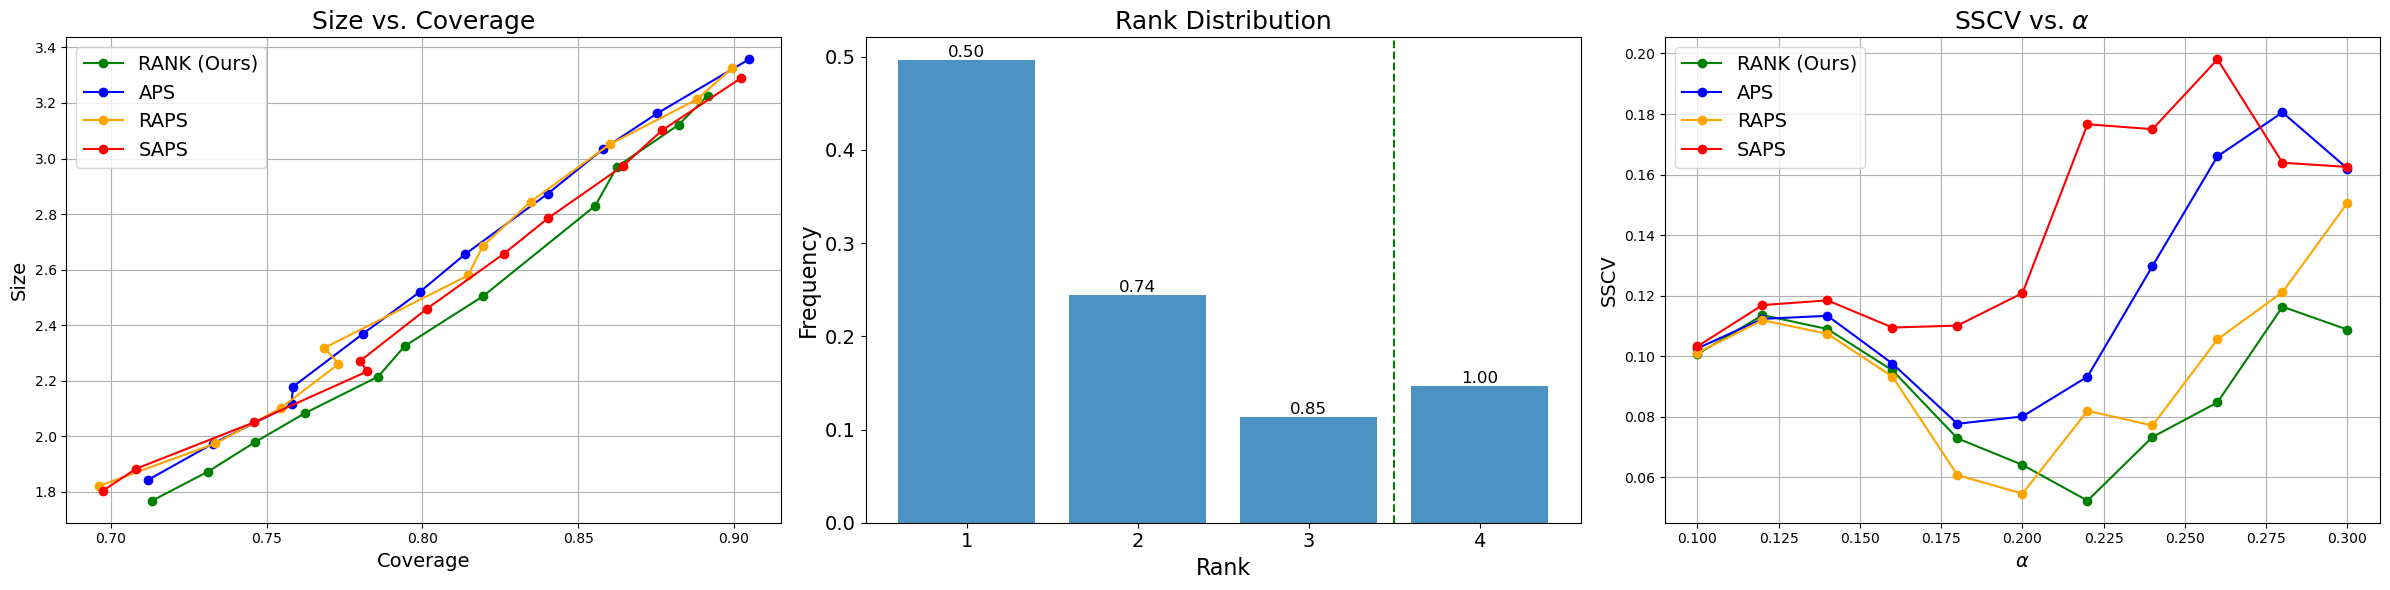

In [71]:
import matplotlib.pyplot as plt
import numpy as np

colors = ['green', 'blue', 'orange', 'red']  # Specify the desired colors
names = ['THRRANK', 'APS', 'RAPS', 'SAPS']
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 6))

# Plot Size vs. Coverage
for idx, score_function in enumerate(score_functions):
    result = results_df[results_df['Score Function'] == names[idx]]
    if score_function == THRRANK:
        ax1.plot(result['Coverage'], result['Size'], color=colors[idx], linestyle='-', marker='o', label="RANK (Ours)")
    else:
        ax1.plot(result['Coverage'], result['Size'], color=colors[idx], linestyle='-', marker='o', label=names[idx])

ax1.set_xlabel('Coverage', fontsize=14)
ax1.set_ylabel('Size', fontsize=14)
ax1.set_title('Size vs. Coverage', fontsize=18)
ax1.legend(loc='upper left', fontsize=14)
ax1.grid(True)

# Convert ranks to integers
ranks = [int(rank) for rank in ranks]

# Get the unique ranks and their frequencies
unique_ranks = sorted(set(ranks))
rank_frequencies = [ranks.count(rank) / len(ranks) for rank in unique_ranks]
unique_ranks = [rank + 1 for rank in unique_ranks]

# Calculate the cumulative distribution
cumulative_distribution = np.cumsum(rank_frequencies)

# Create the histogram
bars = ax2.bar(unique_ranks, rank_frequencies, align='center', alpha=0.8)

# Find the index where the cumulative probability exceeds 0.90
threshold_index = np.argmax(cumulative_distribution > 0.90)

# Print the cumulative distribution on the bars until the first one that exceeds 0.90
for i, bar in enumerate(bars):
    if i <= threshold_index:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width() / 2, height,
                 f'{cumulative_distribution[i]:.2f}', ha='center', va='bottom', fontsize=12)

# Add a vertical line between the bars where the cumulative probability exceeds 0.90
if threshold_index == 0:
    line_position = (unique_ranks[threshold_index])
    ax2.axvline(x=line_position, color='green', linestyle='--', linewidth=1.5)        
else:
    line_position = (unique_ranks[threshold_index] + unique_ranks[threshold_index - 1]) / 2
    ax2.axvline(x=line_position, color='green', linestyle='--', linewidth=1.5)        

# Set the x-tick labels and positions
ax2.set_xticks(unique_ranks)
ax2.set_xticklabels(unique_ranks)

# Set the x-label and y-label
ax2.set_xlabel('Rank', fontsize=16)
ax2.set_ylabel('Frequency', fontsize=16)

# Set the title
ax2.set_title('Rank Distribution', fontsize=18)

# Increase the font size of the tick labels
ax2.tick_params(axis='both', labelsize=14)

# Plot Alpha vs. SSCV
for idx, score_function in enumerate(score_functions):
    result = results_df[results_df['Score Function'] == names[idx]]
    if score_function == THRRANK:
        ax3.plot(result['Alpha'], result['SSCV'], color=colors[idx], linestyle='-', marker='o', label="RANK (Ours)")
    else:
        ax3.plot(result['Alpha'], result['SSCV'], color=colors[idx], linestyle='-', marker='o', label=names[idx])

ax3.set_xlabel('$\\alpha$', fontsize=14)
ax3.set_ylabel('SSCV', fontsize=14)
ax3.set_title('SSCV vs. $\\alpha$', fontsize=18)
ax3.legend(loc='upper left', fontsize=14)
ax3.grid(True)

plt.tight_layout()
plt.show()
fig.savefig(os.path.join('figure', f'{file}.pdf'))

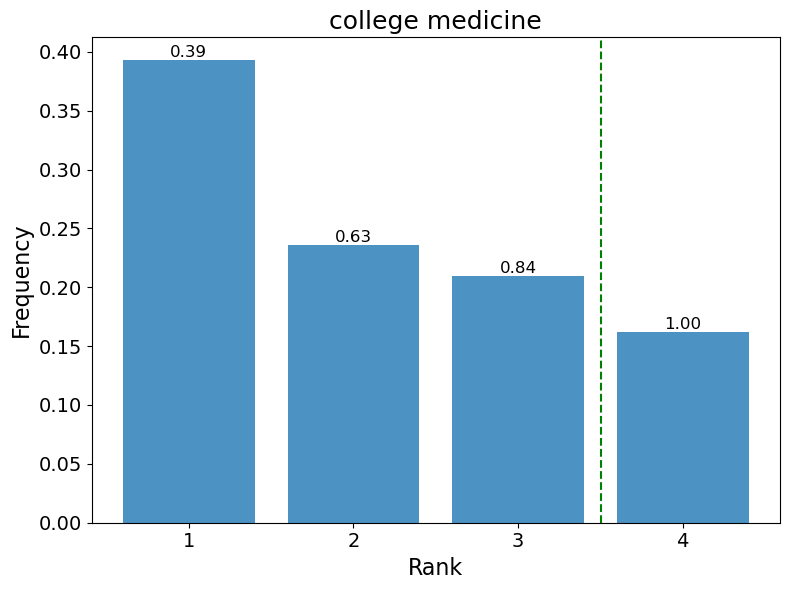

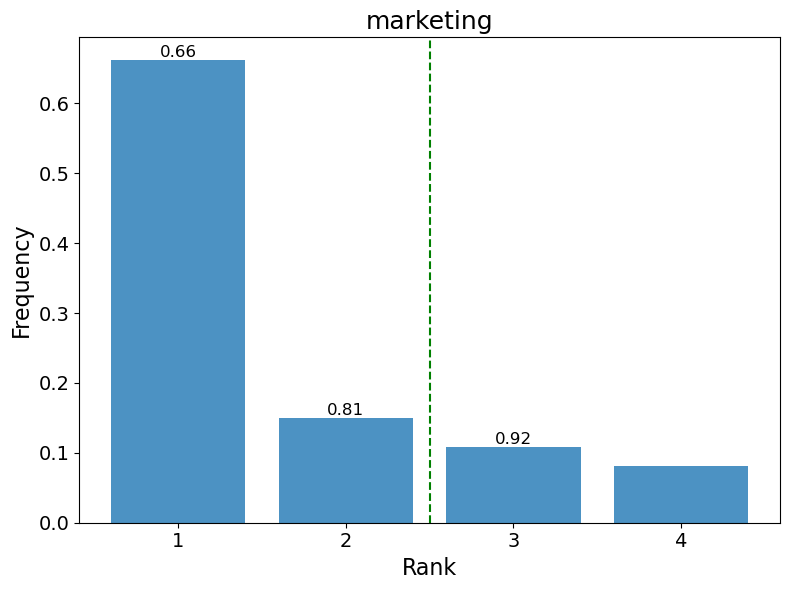

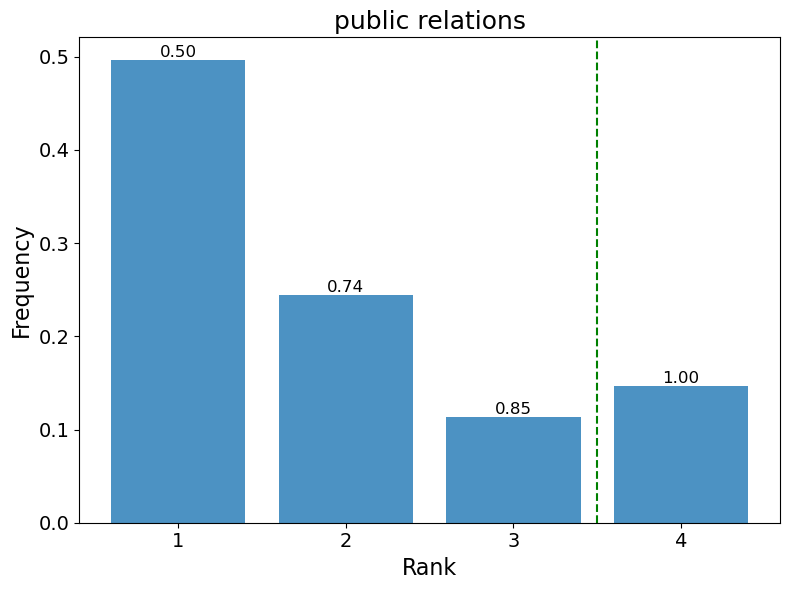

In [30]:
for name, results in datasets.items():
    scores = torch.from_numpy(results['scores'][0])
    targets = torch.from_numpy(results['targets'])
    torch.save({'logits': scores, 'labels': targets}, f'logits_labels_{name}.pt')

    ordered, indices = torch.sort(scores, dim=-1, descending=True)
    _, sorted_indices = torch.sort(indices, descending=False, dim=-1)
    ranks = sorted_indices[torch.arange(scores.shape[0]), targets]
    plot_rank_histogram(ranks.numpy(), name)


In [37]:
subject_name = 'marketing'
results_df[results_df['Data']==subject_name].to_csv(f"{subject_name}.csv")

In [ ]:
print(f'COVERAGE at alpha: {alpha}')
print()
mean_coverage = np.zeros((len(other_all_coverage), len(other_all_coverage)))
for i, (first_dataset, results) in enumerate(other_all_coverage.items()):
    print(first_dataset.center(50, '-'))
    for j, (second_dataset, coverage) in enumerate(results.items()):
        if second_dataset == first_dataset:
            print(second_dataset, f'{np.mean(coverage):.0%} +/- {np.std(coverage):.0%}')
            print()
        mean_coverage[i][j] = np.mean(coverage)

print('********************')
print(f'SET SIZES at alpha: {alpha}')
print()

mean_size = np.zeros((len(other_all_size), len(other_all_size)))
for i, (first_dataset, results) in enumerate(other_all_size.items()):
    print(first_dataset.center(50, '-'))
    for j, (second_dataset, size) in enumerate(results.items()):
        if second_dataset == first_dataset:
            print(second_dataset, f'{np.mean(size):.1f} +/- {np.std(size):.1f}')
            print()
        mean_size[i][j] = np.mean(size)

In [ ]:
fontsize = 32

# plot coverage between subjects
plt.figure(figsize=(8, 12))
bars = plt.barh(list(datasets.keys()), [mean_coverage[i][i] for i in range(mean_coverage.shape[0])])
bars[5].set_color('C2')
bars[6].set_color('C2')
bars[7].set_color('C2')
bars[8].set_color('C2')
bars[9].set_color('C2')
bars[10].set_color('C2')
bars[11].set_color('C1')
bars[12].set_color('C1')
bars[13].set_color('C1')
bars[14].set_color('C1')
bars[15].set_color('C1')
# plt.axhline(10.5, ls='-', lw=2, c='k')
# plt.axhline(4.5, ls='-', lw=2, c='k')
plt.axvline(0.9, ls='--', lw=6, c='r')
plt.xlim(0.5, 1)
plt.xticks([0.5, 0.6, 0.7, 0.8, 0.9, 1], fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.gca().set_xticklabels([f'{x:.0%}' for x in plt.gca().get_xticks()])
plt.xlabel('Coverage', fontsize=fontsize)
# plt.ylabel('Datasets', fontsize=fontsize)
plt.grid(ls='-', axis='x')
plt.savefig('coverage.eps', bbox_inches='tight')
plt.show()

# plot set size between subjects
plt.figure(figsize=(8, 12))
bars = plt.barh(list(datasets.keys()), [mean_size[i][i] for i in range(mean_size.shape[0])])
bars[5].set_color('C2')
bars[6].set_color('C2')
bars[7].set_color('C2')
bars[8].set_color('C2')
bars[9].set_color('C2')
bars[10].set_color('C2')
bars[11].set_color('C1')
bars[12].set_color('C1')
bars[13].set_color('C1')
bars[14].set_color('C1')
bars[15].set_color('C1')
plt.xlim(1, 4)
# plt.axvline(0.8, ls='--', lw=6, c='r')
# plt.axhline(10.5, ls='-', lw=2, c='k')
# plt.axhline(4.5, ls='-', lw=2, c='k')
plt.xticks([1, 2, 3, 4], fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.xlabel('Conformal prediction set size', fontsize=fontsize)
# plt.ylabel('Datasets', fontsize=fontsize)
plt.grid(ls='-', axis='x')
plt.savefig('size.eps', bbox_inches='tight')
plt.show()

In [ ]:
names = list(datasets.keys())

In [ ]:
# plot deviation from desired coverage when calibrating quantile on out of subject MCQA data
plt.figure(figsize=(12, 12))
plt.grid(False)
plt.imshow(
    mean_coverage - (1-alpha),
    # cmap=plt.get_cmap('seismic'),
    cmap=plt.get_cmap('RdYlGn'),
)
plt.xticks(np.arange(len(names)) + 0.5, names, fontsize=fontsize-4, rotation=50, ha='right', va='top')
plt.yticks(np.arange(len(names)) - 0.1, names, fontsize=fontsize-4)
plt.xlabel('Evaluated on', fontsize=fontsize+8)
plt.ylabel('Calibrated on', fontsize=fontsize+8)
plt.axhline(10.5, ls='-', lw=6, c='k')
plt.axhline(4.5,  ls='-', lw=6, c='k')
plt.axvline(10.5, ls='-', lw=6, c='k')
plt.axvline(4.5,  ls='-', lw=6, c='k')
cax = plt.axes([0.93, 0.11, 0.075, 0.77])
cbar = plt.colorbar(cax=cax)
cbar.ax.tick_params(labelsize=fontsize)
cbar.ax.set_yticklabels([f'{x:.1%}' for x in cbar.ax.get_yticks()])
# plt.tick_params('x')
plt.savefig(f'calibration-{alpha}.eps', bbox_inches='tight')
plt.show()

In [ ]:
def get_accuracy(scores, targets):
    n = len(scores)
    correct = (scores.argmax(1) == targets).sum()
    accuracy = correct / n

    return accuracy

acc_results = {}
cov_results = {}
for dataset in datasets.keys():
    stratified_coverage = defaultdict(list)
    stratified_accuracy = defaultdict(list)
    stratified_count = defaultdict(list)
    for k in range(1, 5):
        for i, psets in enumerate(all_psets[dataset]):
            mask = psets.sum(1) == k
            psets = psets[mask]
            scores = all_scores[dataset][i][mask]
            stratified_coverage[k].append(get_coverage(psets, all_targets[dataset][i][mask]))
            stratified_accuracy[k].append(get_accuracy(scores, all_targets[dataset][i][mask]))

    # plt.plot(stratified_coverage.keys(), stratified_coverage.values(), label=dataset)
    acc_results[dataset] = dict(stratified_accuracy)
    cov_results[dataset] = dict(stratified_coverage)
    # cnt_results[dataset] = stratified_count


### How often is the model right at a specific prediction set size (model uncertainty)

We expect the model to be right more often when it is more confident (small prediction sets) and wrong when the prediction sets are large.

In [ ]:
fontsize = 24
plt.figure(figsize=(14, 8))

markers = ['o', '^', 'p', 'd', '*'] + ['o', '^', 'p', 'd', '*', 's'] + ['o', '^', 'p', 'd', '*']
for i, (dataset, acc) in enumerate(acc_results.items()):
    if dataset in names[:5]:
        c = 'C0'
    elif dataset in names[5:11]:
        c = 'C2'
    elif dataset in names[10:]:
        c = 'C1'
    plt.plot(acc.keys(), [np.mean(x) for x in acc.values()], label=dataset, ls='--', marker=markers[i], markersize=10, c=c, markeredgecolor='k')

plt.legend(fontsize=fontsize-4, bbox_to_anchor=(1.1, 1.50), ncol=3)
plt.xticks([1, 2, 3, 4], fontsize=fontsize)
plt.yticks(np.arange(0.0, 1.1, 0.1), fontsize=fontsize)
plt.gca().set_yticklabels([f'{x:.0%}' for x in plt.gca().get_yticks()])
plt.xlabel('Conformal prediction set size', fontsize=fontsize+8)
plt.ylabel('Top-1 accuracy', fontsize=fontsize+8)
plt.grid(True,)
plt.savefig('selective-accuracy.eps', bbox_inches='tight')
plt.show()

### What percent of the time is the true answer one of the predicted answers in the prediction set?

In [ ]:
fontsize = 24
plt.figure(figsize=(14, 8))

for i, (dataset, acc) in enumerate(cov_results.items()):
    if dataset in names[:5]:
        c = 'C0'
    elif dataset in names[5:11]:
        c = 'C2'
    elif dataset in names[10:]:
        c = 'C1'
    plt.plot(acc.keys(), [np.mean(x) for x in acc.values()], label=dataset, ls='--', marker=markers[i], markersize=12, c=c, markeredgecolor='k')

plt.legend(fontsize=fontsize-4, bbox_to_anchor=(1.1, 1.50), ncol=3)
plt.xticks([1, 2, 3, 4], fontsize=fontsize)
plt.yticks(np.arange(0, 1.1, 0.1), fontsize=fontsize)
plt.gca().set_yticklabels([f'{x:.0%}' for x in plt.gca().get_yticks()])
plt.xlabel('Conformal prediction set size', fontsize=fontsize+8)
plt.ylabel('Coverage', fontsize=fontsize+8)
plt.grid(True,)
plt.savefig('stratified-coverage.eps', bbox_inches='tight')
plt.show()

### How does conformal compare to just always taking the "top-k" highest softmax scores?

In [ ]:
naive_results = {}
for dataset in datasets.keys():
    naive_coverage = defaultdict(list)
    for k in range(1, 5):
        for i, scores in enumerate(all_scores[dataset]):
            sorted_scores = np.flip(scores.argsort(), 1)[:, :k]
            psets = np.eye(4)[sorted_scores].sum(1)
            naive_coverage[k].append(get_coverage(psets.copy(), all_targets[dataset][i]))

    naive_results[dataset] = dict(naive_coverage)

fontsize = 24
plt.figure(figsize=(14, 8))

for i, (dataset, acc) in enumerate(naive_results.items()):
    if dataset in names[:5]:
        c = 'C0'
    elif dataset in names[5:11]:
        c = 'C2'
    elif dataset in names[10:]:
        c = 'C1'
    plt.plot(acc.keys(), [np.mean(x) for x in acc.values()], label=dataset, ls='--', marker=markers[i], markersize=12, c=c, markeredgecolor='k')

plt.legend(fontsize=fontsize-4, bbox_to_anchor=(1.1, 1.50), ncol=3)
plt.xticks([1, 2, 3, 4], fontsize=fontsize)
plt.yticks(np.arange(0.2, 1.1, 0.1), fontsize=fontsize)
plt.gca().set_yticklabels([f'{x:.0%}' for x in plt.gca().get_yticks()])
plt.xlabel('Naive prediction set size', fontsize=fontsize+8)
plt.ylabel('Coverage', fontsize=fontsize+8)
plt.grid(True,)
plt.savefig('navie-coverage.eps', bbox_inches='tight')
plt.show()

### Comparing accuracy using real (MMLU) vs generated (GPT-4) question-answer examples in the prompt template

In [ ]:
import pickle

In [ ]:
with open('../../../accuracy_gpt_prompts_10.pkl', 'rb') as f:
    gpt_acc = pickle.load(f)

with open('../../../accuracy_mmlu_prompts_10.pkl', 'rb') as f:
    mmlu_acc = pickle.load(f)

In [ ]:
plt.figure(figsize=(9, 10))
names = []
counter = 0
for name in datasets.keys():
    dataset = name.replace(' ', '_')
    if dataset in gpt_acc and dataset in mmlu_acc:
        names.append(name)
        if counter == 0:
            gpt_label = 'GPT-4'
            mmlu_label = 'MMLU'
        else:
            gpt_label = None
            mmlu_label = None
        plt.scatter(np.mean(gpt_acc[dataset]), counter, label=gpt_label, c='C0', s=300, marker='^')
        plt.scatter(np.mean(mmlu_acc[dataset]), counter, label=mmlu_label, c='C1', s=300, marker='^')
        counter += 1

# plt.axhline(11.5, ls='-', lw=2, c='k')
# plt.axhline(5.5, ls='-', lw=2, c='k')
plt.yticks(range(len(names)), fontsize=12)
plt.gca().set_xticklabels([f'{x:.0%}' for x in plt.gca().get_xticks()], fontsize=fontsize-4)
plt.gca().set_yticklabels(names, fontsize=fontsize)
plt.xlabel('Accuracy', fontsize=fontsize)
# plt.ylabel('Datasets', fontsize=fontsize)
plt.grid(ls='-', axis='both')
plt.legend(fontsize=fontsize, title='One-shot prompt', title_fontsize=fontsize, bbox_to_anchor=(0.9, 1.20), ncol=2)
plt.savefig('gpt-vs-mmlu.eps', bbox_inches='tight')
plt.show()